# **<font color="#ffb94f">0.0 PREPARATION</font>**

In [ ]:
# In case of running on Google Colab
%%capture

# !apt-get install -qq curl g++ make
# !curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
# import os
# os.chdir('spatialindex-src-1.8.5')
# !./configure
# !make
# !make install
# !pip install rtree
# !ldconfig
# !pip install scikit-mobility

In [ ]:
%%capture
# Importing libraries
import numpy as np
import random
import pandas as pd
import datetime
import collections
from sklearn.impute import SimpleImputer

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.ticker as ticker
import plotly
import plotly.graph_objects as go
import seaborn as sns

# Geospatial analysis
!pip install geovoronoi
!pip install geopandas
!pip install folium
import geopandas as gpd
import folium
from scipy.stats import gaussian_kde, iqr
from scipy.spatial import Voronoi, voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.ops import unary_union

# Outlier Detection
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.ensemble import IsolationForest

# Dimensionality Reduction
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2
from sklearn.decomposition import PCA
from sklearn import random_projection

# import skmob
# from skmob.tessellation import tilers
# from skmob.models.epr import DensityEPR, SpatialEPR, Ditras
# from skmob.models.markov_diary_generator import MarkovDiaryGenerator
# from skmob.preprocessing import filtering, compression, detection, clustering
# from skmob.measures.individual import jump_lengths, radius_of_gyration, uncorrelated_entropy, number_of_locations, number_of_visits, location_frequency
# from skmob.measures.collective import visits_per_location
# from skmob.utils.plot import *
# from skmob.data.load import load_dataset, list_datasets

# import sklearn
# from sklearn.metrics import mean_squared_error

In [ ]:
# Setting up plot style
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":16,"axes.labelsize":14})
sns.set_style("whitegrid", {'grid.linestyle': '--', 'alpha': 0.25})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})

# **<font color="#ffb94f">1.0 DATA UNDERSTANDING & PREPARATION</font>**

## **<font color="#84f745">1.1 DATA UNDERSTANDING</font>**

In [ ]:
# Taking a first look at the dataset
air_quality_index = 'https://raw.githubusercontent.com/Bruno-Limon/air-quality-analysis/main/AQI-2016.csv'
df_aqi = pd.read_csv(air_quality_index)

df_aqi.head()

Fecha     Hora     CO      NO2       O3   PM 10      SO2  PM2.5   \
0  01/01/2016  0:00:00  1.471  0.02763  0.00472  146.95  0.00306     NaN   
1  01/01/2016  1:00:00  2.653  0.02632  0.00335  216.10  0.00322     NaN   
2  01/01/2016  2:00:00  2.712  0.02698  0.00328  113.44  0.00305     NaN   
3  01/01/2016  3:00:00  2.099  0.02398  0.00348   73.30  0.00259     NaN   
4  01/01/2016  4:00:00  2.019  0.02110  0.00323   52.55  0.00220     NaN   

   Temperatura  Humedad relativa   Velocidad de viento   \
0         18.3               70.3                   2.2   
1         17.3               74.2                   0.4   
2         16.7               76.4                   0.6   
3         16.1               78.4                   1.7   
4         15.7               79.8                   0.2   

   Direccion de vientos   Radiacion solar  Indice UV CASETA   
0                  270.3              NaN        NaN     ATM  
1                  219.5              NaN        NaN     ATM  
2                  215.5              NaN        NaN     ATM  
3                  250.9              NaN        NaN     ATM  
4                  180.6              NaN        NaN     ATM

In [ ]:
df_aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87840 entries, 0 to 87839
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Fecha                  87840 non-null  object 
 1   Hora                   87840 non-null  object 
 2   CO                     77138 non-null  float64
 3   NO2                    78519 non-null  float64
 4   O3                     78647 non-null  float64
 5   PM 10                  45142 non-null  float64
 6   SO2                    57942 non-null  float64
 7   PM2.5                  7459 non-null   float64
 8   Temperatura            69318 non-null  float64
 9   Humedad relativa       78099 non-null  float64
 10  Velocidad de viento    86852 non-null  float64
 11  Direccion de vientos   78410 non-null  float64
 12  Radiacion solar        26295 non-null  float64
 13  Indice UV              8784 non-null   float64
 14  CASETA                 87840 non-null  object 
dtypes:

In [ ]:
# Creating datetime column using date and hour columns
df_aqi.insert(0, 'Datetime', pd.to_datetime(df_aqi['Fecha'] + ' ' + df_aqi['Hora']))
df_aqi.drop(['Fecha', 'Hora'], axis = 1, inplace = True)

# Looking at unique values and time span
print('Distinct monitoring stations:', df_aqi['CASETA '].unique())
print('Earliest date:', df_aqi['Datetime'].min())
print('Latest date:', df_aqi['Datetime'].max())

Distinct monitoring stations: ['ATM' 'OBL' 'PIN' 'SFE' 'TLA' 'VAL' 'CEN' 'AGU' 'LDO' 'MIR']
Earliest date: 2016-01-01 00:00:00
Latest date: 2016-12-31 23:00:00


In [ ]:
# Mapping the 3 letter code of monitoring stations to their full name, for clarity
dict_caseta = {'ATM': 'Atemajac',
               'OBL': 'Oblatos', 
               'PIN': 'Las Pintas', 
               'SFE': 'Santa Fe', 
               'TLA': 'Tlaquepaque', 
               'VAL': 'Vallarta', 
               'CEN': 'Centro',
               'AGU': 'Aguilas',
               'LDO': 'Loma Dorada',
               'MIR': 'Miravalle',}

df_aqi["Caseta"] = df_aqi['CASETA '].map(dict_caseta)
df_aqi.drop(['CASETA '], axis = 1, inplace = True)

MISSING DATA

In [ ]:
# Looking at the amount of null values across features
print(df_aqi.isnull().sum(axis = 0))

# Dropping unncessary features or those with over 50% missing values
to_drop = ['PM2.5 ', 'Radiacion solar', 'Indice UV', 'Direccion de vientos ']
df_aqi.drop(to_drop, axis = 1, inplace = True)
df_aqi.rename(columns={'Humedad relativa ':'Humidity', 
                       'Velocidad de viento ':'Wind velocity',
                       'Caseta':'Station',
                       'Temperatura':'Temperature'}, inplace=True)

Datetime                     0
CO                       10702
NO2                       9321
O3                        9193
PM 10                    42698
SO2                      29898
PM2.5                    80381
Temperatura              18522
Humedad relativa          9741
Velocidad de viento        988
Direccion de vientos      9430
Radiacion solar          61545
Indice UV                79056
Caseta                       0
dtype: int64


In [ ]:
list_monitor_station = list(df_aqi['Station'].unique())
list_columns = list(df_aqi.columns.values)

# Creating list containing null values filtered by the monitoring station
list_nulls = []
for i, station in enumerate(list_monitor_station):
    list_nulls.append([])
    for j in range(df_aqi.shape[1]):
        list_nulls[i].append(df_aqi.loc[df_aqi['Station'] == station].iloc[:,j].isnull().sum())

# Putting the lists into a dataframe
df_aqi_nulls = pd.DataFrame(np.column_stack([list_nulls[i] for i in range(len(list_nulls))]),
                            columns = list_monitor_station,
                            index = list_columns)
df_aqi_nulls.T

Datetime    CO   NO2    O3  PM 10   SO2  Temperature  Humidity  \
Atemajac            0   605   604   929   5241   671           73        73   
Oblatos             0   457   553   533   5032   566           16        16   
Las Pintas          0  1479  1002   936   3341  7838            6         6   
Santa Fe            0  1077   986  1381   1305  6486         8784      8784   
Tlaquepaque         0   489   475   646   4911   477           70        70   
Vallarta            0  1176   554   412   4901  2555           20        20   
Centro              0  3024   391   640   4977  1142         8784         3   
Aguilas             0   372  1507   358   5140  3955            5         5   
Loma Dorada         0   310   922  1071   1166  2844          422       422   
Miravalle           0  1713  2327  2287   6684  3364          342       342   

             Wind velocity  Station  
Atemajac                73        0  
Oblatos                 16        0  
Las Pintas               6        0  
Santa Fe                31        0  
Tlaquepaque             70        0  
Vallarta                20        0  
Centro                   3        0  
Aguilas                  5        0  
Loma Dorada            422        0  
Miravalle              342        0

As seen from the previous dataframe, some monitoring stations must have had some sensors not functioning thruoughout the year, such as temperature and humidity in the "Santa Fe" station, since every value concerning them is missing.

This might make these stations useless for some of the analysis and algorithms applied to the data

In [ ]:
# Dealing with missing values with different methods, imputing with mean, median, forward filling and dropping them altogether
df_aqi_imputed1 = df_aqi.fillna(df_aqi.mean())
df_aqi_imputed2 = df_aqi.fillna(df_aqi.median())
df_aqi_imputed3 = df_aqi.fillna(method = "ffill")
df_aqi_dropna = df_aqi.dropna()

<ipython-input-9-907bfc08b594>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_aqi_imputed1 = df_aqi.fillna(df_aqi.mean())
<ipython-input-9-907bfc08b594>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_aqi_imputed1 = df_aqi.fillna(df_aqi.mean())
<ipython-input-9-907bfc08b594>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_aqi_imputed2 = df_aqi.fillna(df_aqi.median())
<ipython-input-9-907bfc08b594>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

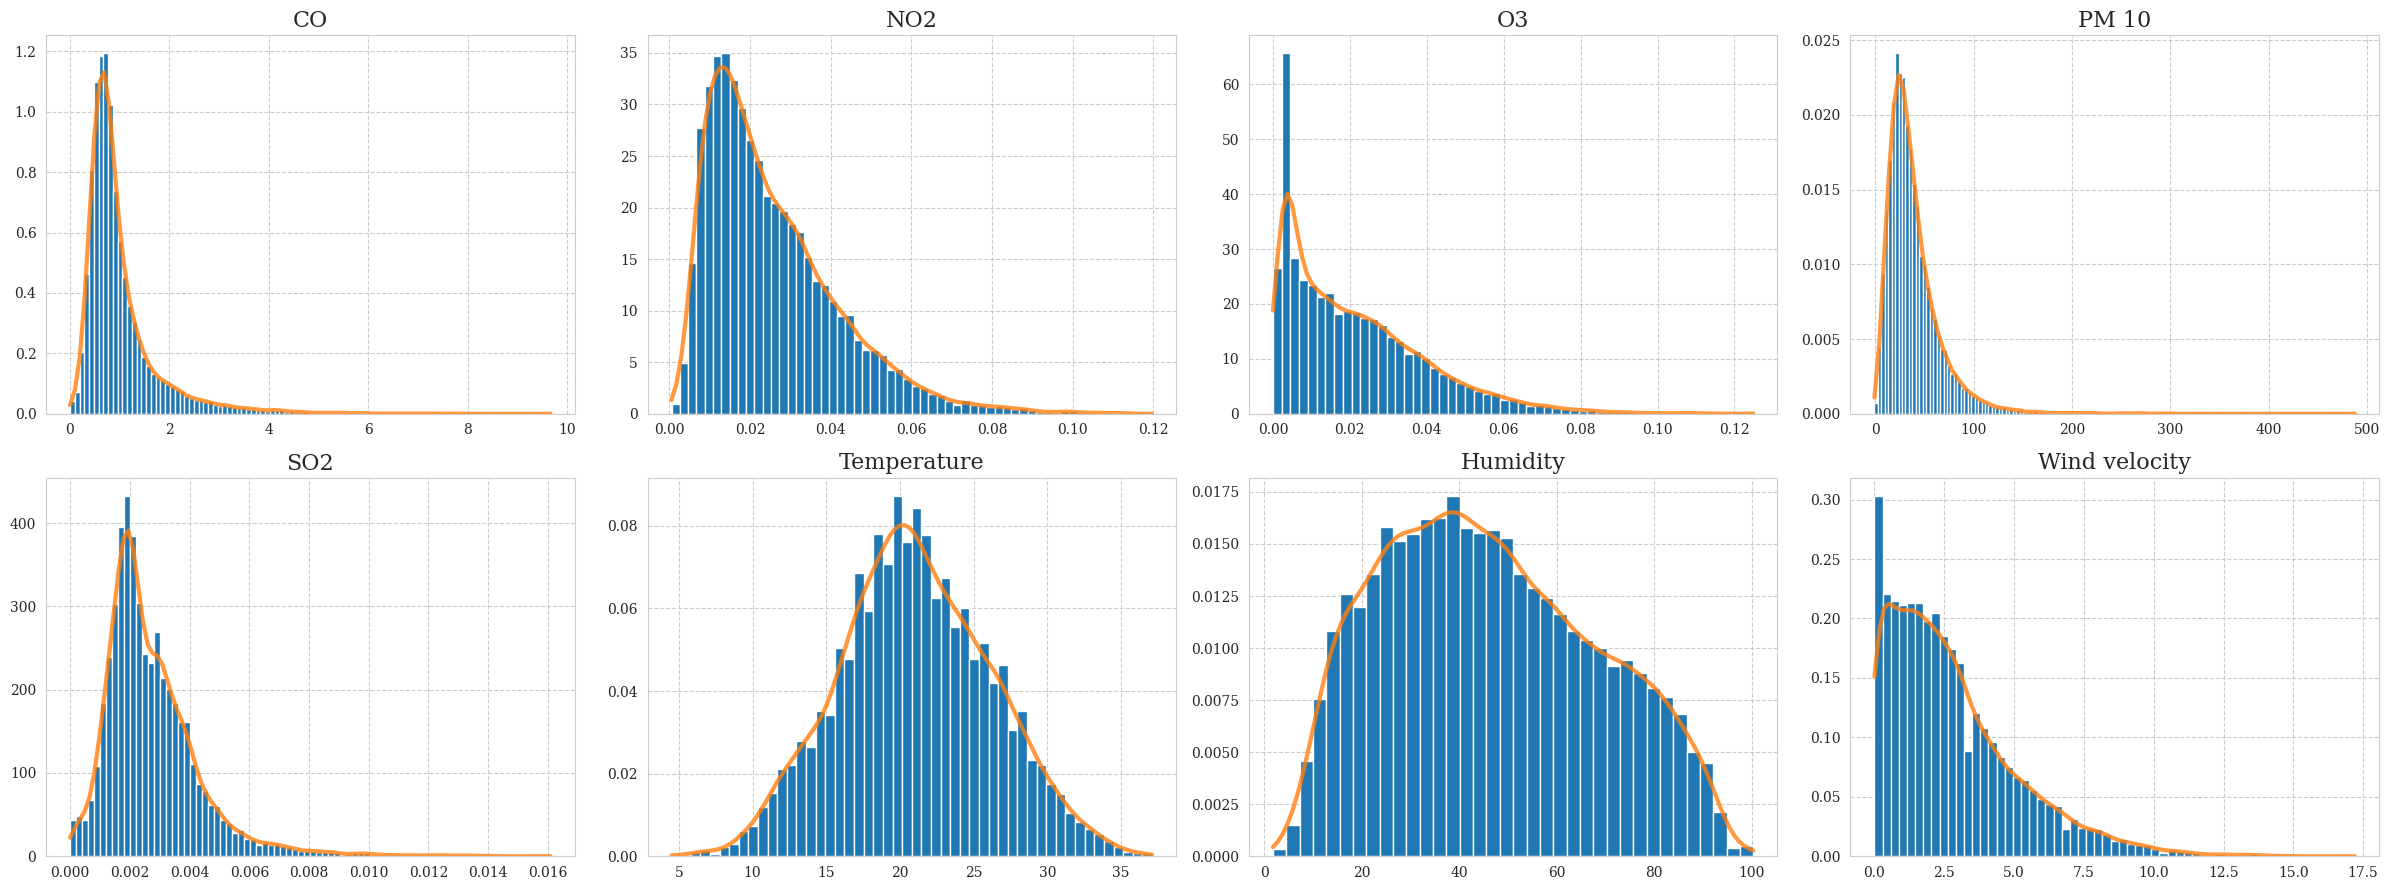

In [ ]:
list_columns = list(df_aqi.columns.values)[1:9]
list_values_dropna = [df_aqi_dropna.iloc[:,i].values for i in range(1,9)]
list_imputed_values1 = [df_aqi_imputed1.iloc[:,i].values for i in range(1,9)]
list_imputed_values2 = [df_aqi_imputed2.iloc[:,i].values for i in range(1,9)]
list_imputed_values3 = [df_aqi_imputed3.iloc[:,i].values for i in range(1,9)]

# Obtaining distribution of each feature using KDE method
list_x = []
list_y = []
list_x1 = []
list_y1 = []
list_x2 = []
list_y2 = []
list_x3 = []
list_y3 = []

for i in range(len(list_values_dropna)):
    kde = gaussian_kde(list_values_dropna[i])
    x = np.linspace(min(list_values_dropna[i]), max(list_values_dropna[i]), 100)
    list_x.append(x)
    list_y.append(kde(x))

    kde1 = gaussian_kde(list_imputed_values1[i])
    x1 = np.linspace(min(list_imputed_values1[i]), max(list_imputed_values1[i]), 100)
    list_x1.append(x1)
    list_y1.append(kde1(x1))

    kde2 = gaussian_kde(list_imputed_values2[i])
    x2 = np.linspace(min(list_imputed_values2[i]), max(list_imputed_values2[i]), 100)
    list_x2.append(x2)
    list_y2.append(kde2(x2))

    kde3 = gaussian_kde(list_imputed_values3[i])
    x3 = np.linspace(min(list_imputed_values3[i]), max(list_imputed_values3[i]), 100)
    list_x3.append(x3)
    list_y3.append(kde3(x3))

# Plotting histogram for each feature in dataset
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 9))
k = 0
for i in range(2):
    for j in range(4):
        ax[i,j].hist(list_values_dropna[k], bins = 'scott', density = True)
        ax[i,j].plot(list_x[k], list_y[k], linewidth = 3, alpha = .8)
        ax[i,j].set(title = list_columns[k])
        fig.tight_layout()
        k += 1

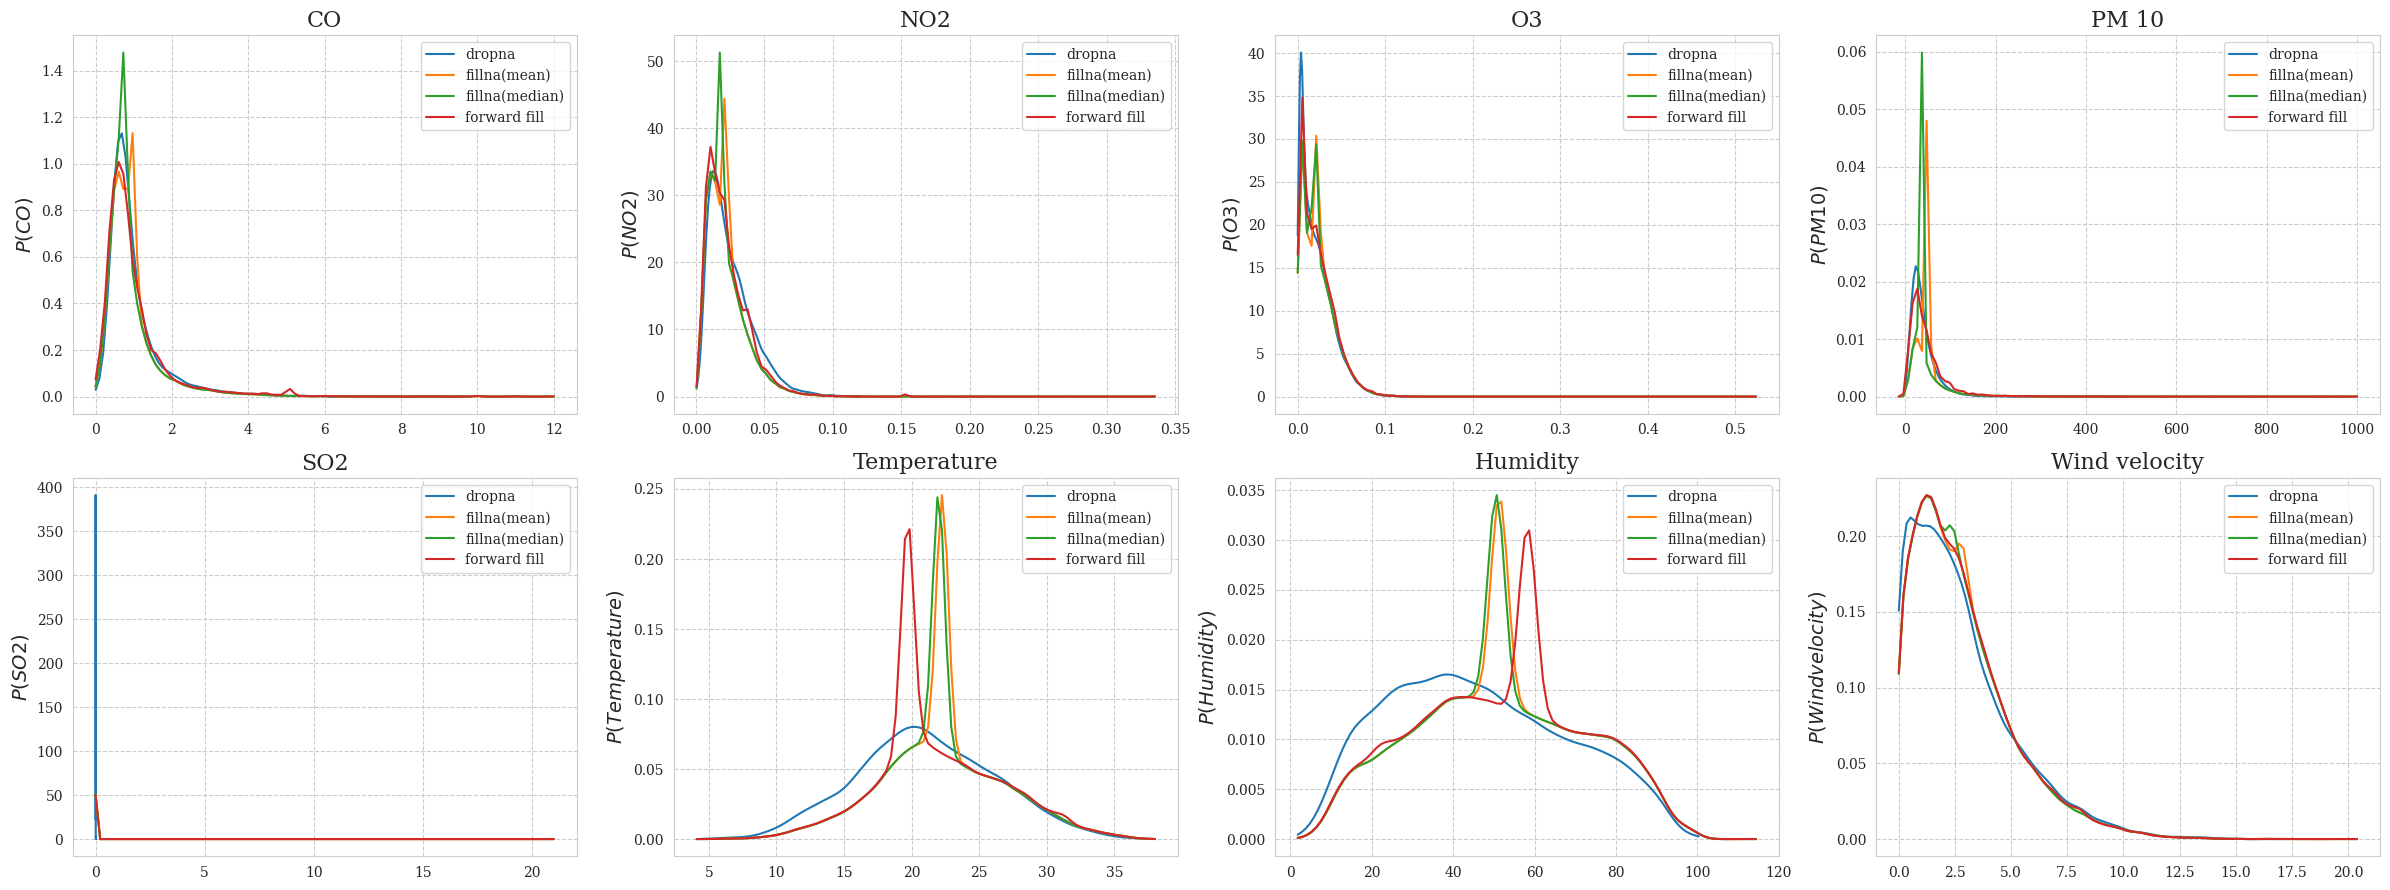

In [ ]:
# Plotting distributions
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 9))
k = 0
for i in range(2):
    for j in range(4):
        ax[i,j].plot(list_x[k], list_y[k], label = 'dropna')
        ax[i,j].plot(list_x1[k], list_y1[k], label = 'fillna(mean)')
        ax[i,j].plot(list_x2[k], list_y2[k], label = 'fillna(median)')
        ax[i,j].plot(list_x3[k], list_y3[k], label = 'forward fill')
        ax[i,j].legend(loc = 'best')
        ax[i,j].set(title = list_columns[k])
        ax[i,j].set(ylabel = "$P({})$".format(list_columns[k]))
        fig.tight_layout()
        k += 1

Looking at the comparison of different methods to deal with missing values, forward filling seems to be closer to the distribution of the values omitting NA, such is the case for the 1st 4 features for example, then, when looking at temperature and humidity, we get confirmation of the undesirable effects that imputing a large amount of values can heavily bias the distribution, by adding synthetic density into the mean areas of the distribution

Another interesting thing to note is that the distribution of SO2 went from a range of 0-0.016 when omitting nan values to 0-20 when imputing said values, given the orders of magnitude of this change, it might prove to be an anomaly

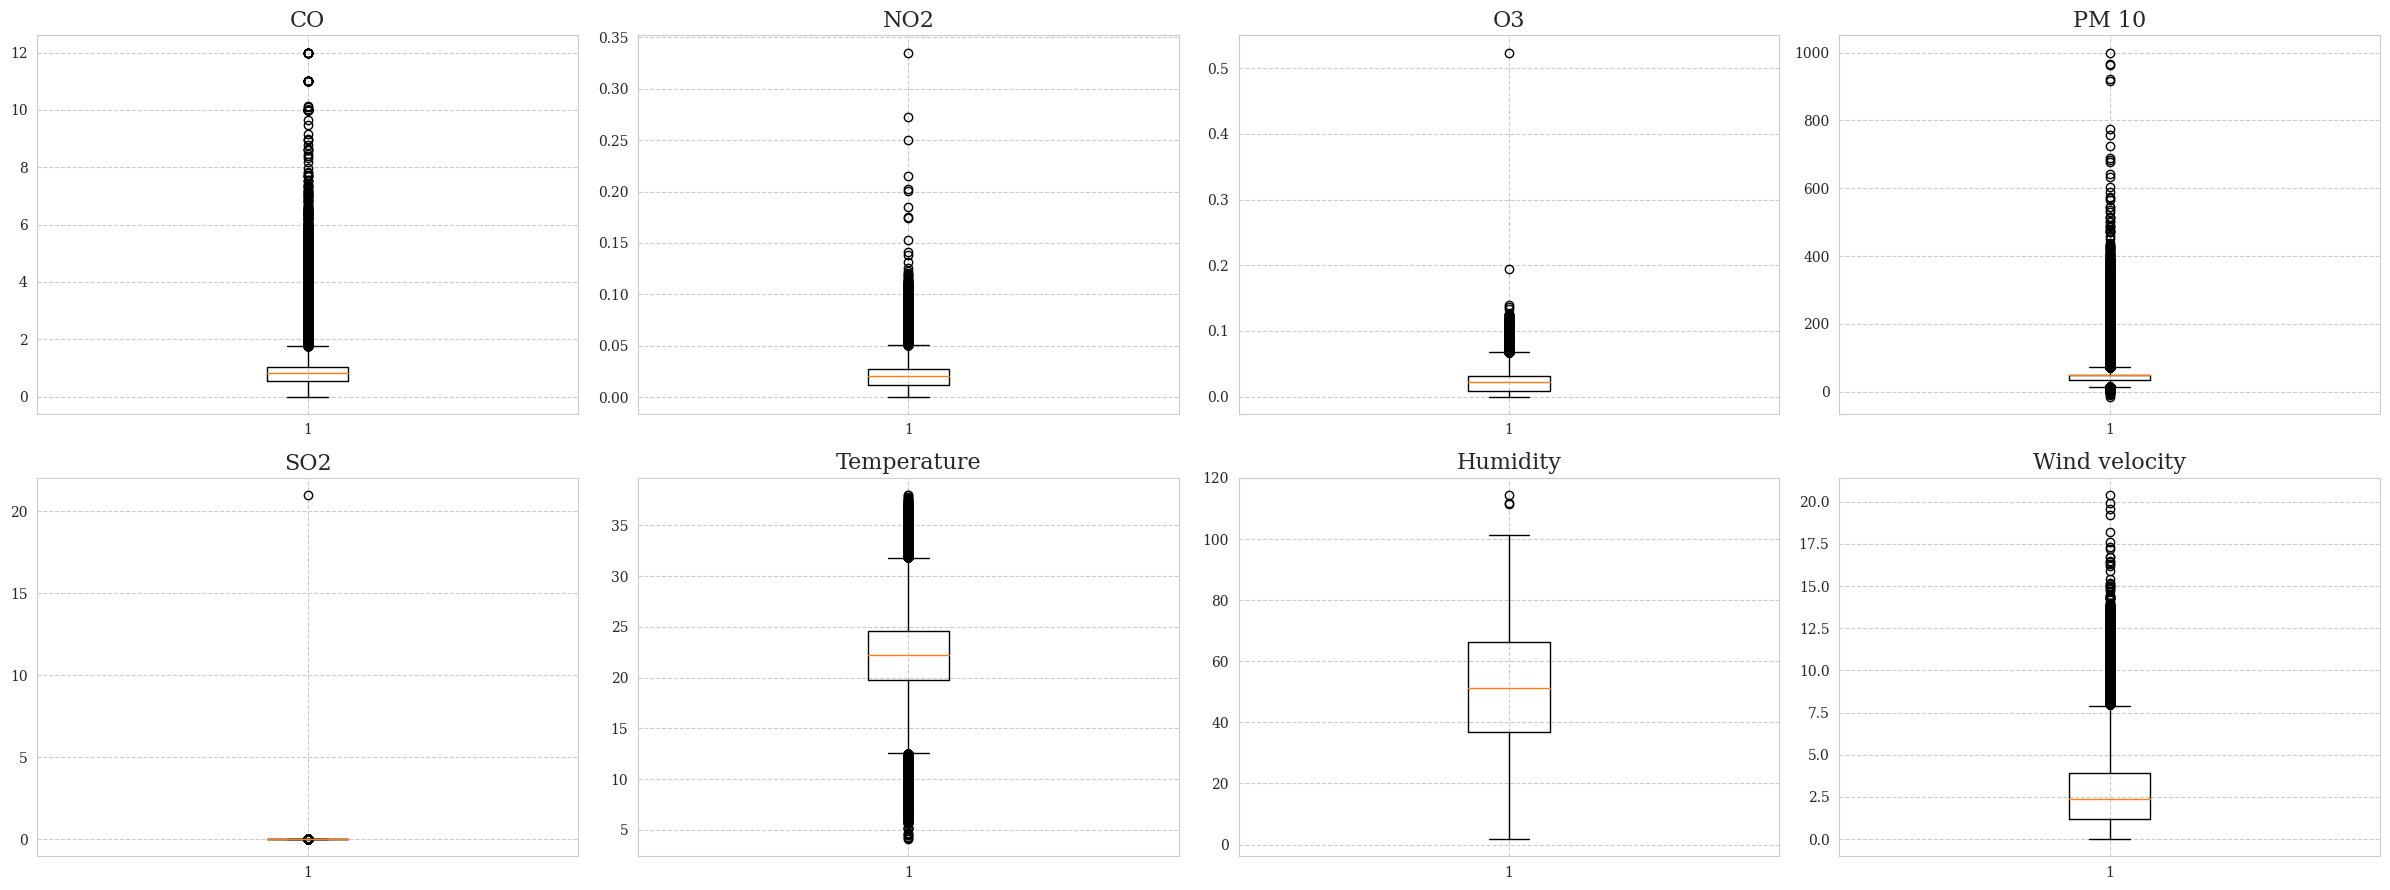

In [ ]:
# Plotting histogram for each feature in dataset of values imputed with the mean to look deeper into the SO2 anomaly
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 9))
k = 0
for i in range(2):
    for j in range(4):
        ax[i,j].boxplot(list_imputed_values1[k])
        ax[i,j].set(title = list_columns[k])
        fig.tight_layout()
        k += 1

In [ ]:
# Intuition was correct, SO2 contains a single outlier that completely skews the distribution
# To get a confirmation, we look at the 5 largest values of SO2
print('Top 5 SO2 values\n', df_aqi['SO2'].nlargest(5), '\n', sep="")
print('Top 5 O3 values\n', df_aqi['O3'].nlargest(5), sep="")

Top 5 SO2 values
43816    21.00000
19798     0.02722
27165     0.02147
26864     0.01973
79988     0.01933
Name: SO2, dtype: float64

Top 5 O3 values
14554    0.52392
54498    0.19370
56560    0.13908
21422    0.13695
56559    0.13385
Name: O3, dtype: float64


In [ ]:
%%capture
# Removing the monitoring stations with features consisting entirely of missing values as well as the anomaly in SO2
df_aqi_clean = df_aqi[df_aqi.Station.str.contains('Santa Fe|Centro') == False]
df_aqi_clean = df_aqi_clean.drop([43816, 14554])

# Re-imputing the values with the new clean dataset
df_aqi_imputed1 = df_aqi_clean.fillna(df_aqi_clean.mean())
df_aqi_imputed2 = df_aqi_clean.fillna(df_aqi_clean.median())
df_aqi_imputed3 = df_aqi_clean.fillna(method = "ffill")
df_aqi_dropna = df_aqi_clean.dropna()

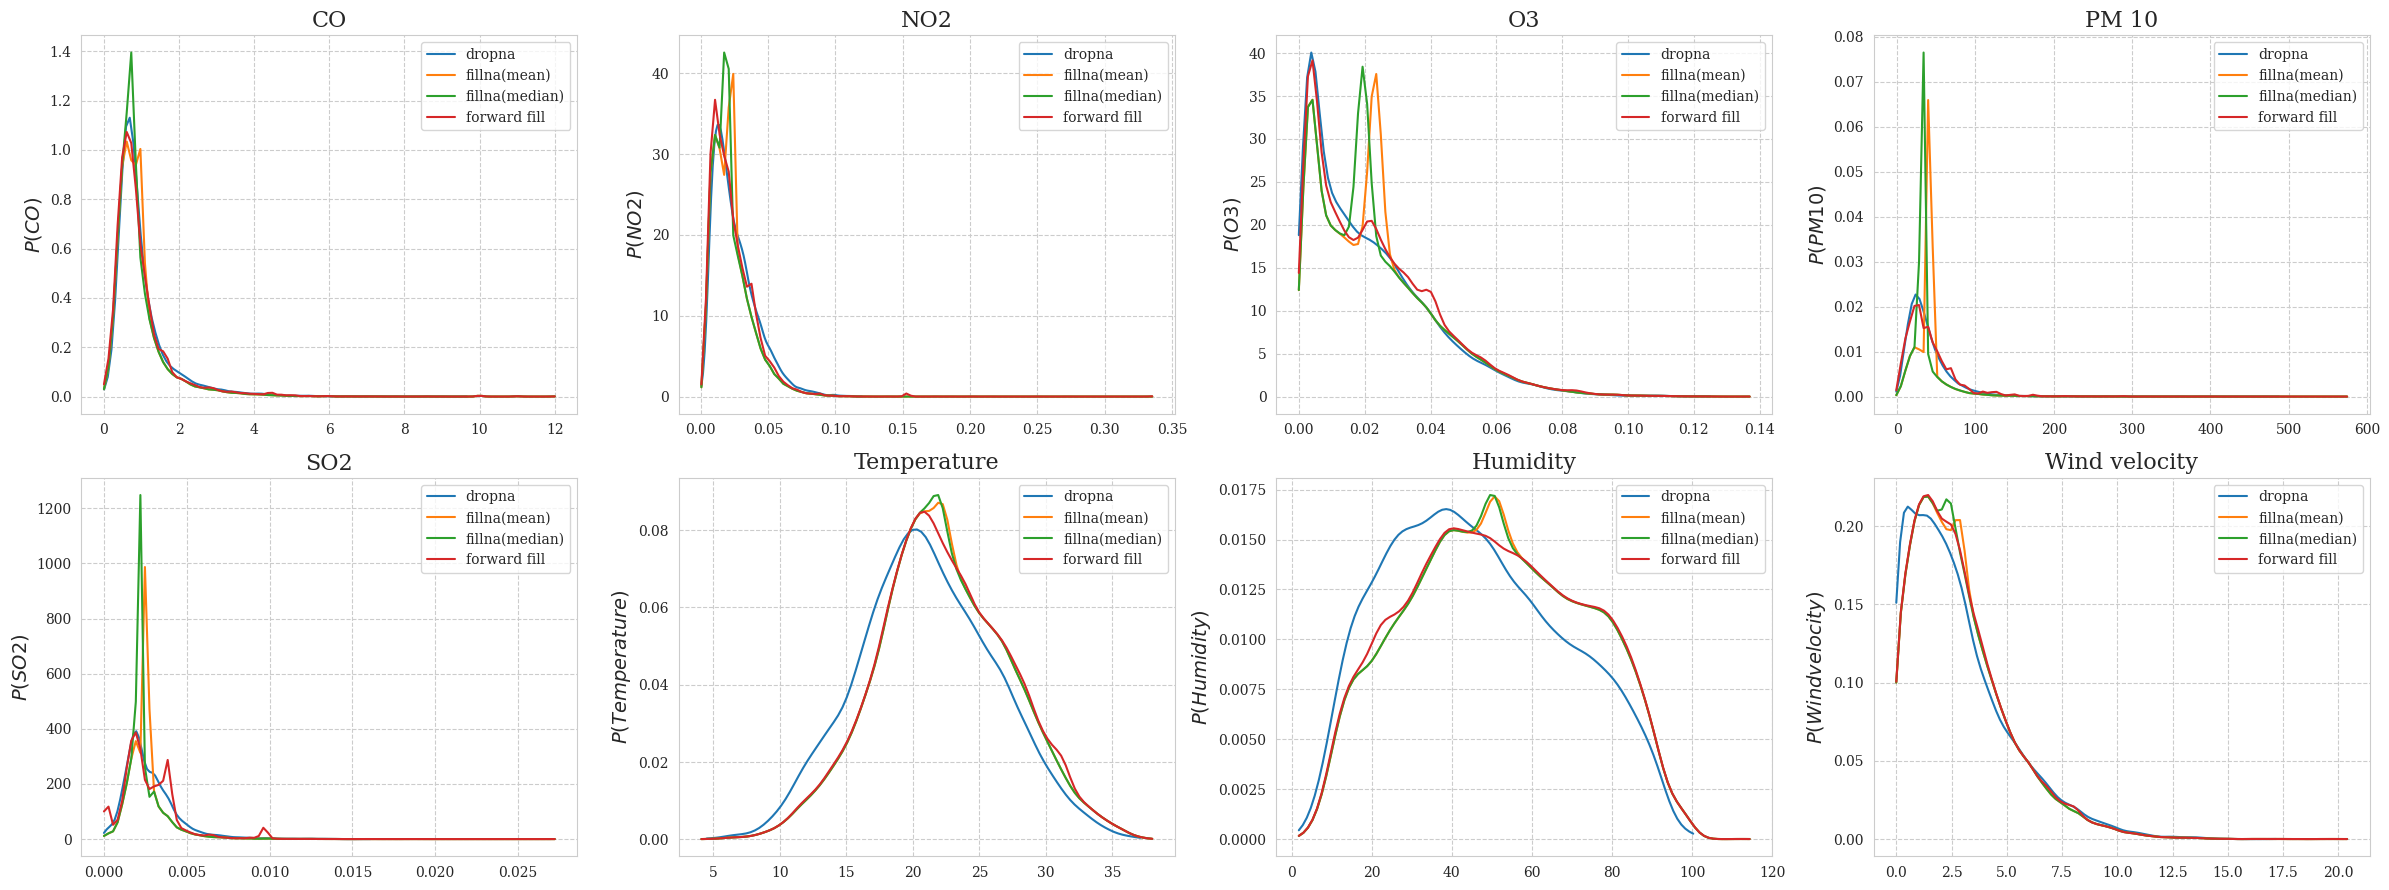

In [ ]:
# Repeating the distribution comparison to see the effects of the recent cleaning
list_columns = list(df_aqi.columns.values)[1:9]
list_values_dropna = [df_aqi_dropna.iloc[:,i].values for i in range(1,9)]
list_imputed_values1 = [df_aqi_imputed1.iloc[:,i].values for i in range(1,9)]
list_imputed_values2 = [df_aqi_imputed2.iloc[:,i].values for i in range(1,9)]
list_imputed_values3 = [df_aqi_imputed3.iloc[:,i].values for i in range(1,9)]

# Obtaining distribution of each feature using KDE method
list_x = []
list_y = []
list_x1 = []
list_y1 = []
list_x2 = []
list_y2 = []
list_x3 = []
list_y3 = []

for i in range(len(list_values_dropna)):
    kde = gaussian_kde(list_values_dropna[i])
    x = np.linspace(min(list_values_dropna[i]), max(list_values_dropna[i]), 100)
    list_x.append(x)
    list_y.append(kde(x))

    kde1 = gaussian_kde(list_imputed_values1[i])
    x1 = np.linspace(min(list_imputed_values1[i]), max(list_imputed_values1[i]), 100)
    list_x1.append(x1)
    list_y1.append(kde1(x1))

    kde2 = gaussian_kde(list_imputed_values2[i])
    x2 = np.linspace(min(list_imputed_values2[i]), max(list_imputed_values2[i]), 100)
    list_x2.append(x2)
    list_y2.append(kde2(x2))

    kde3 = gaussian_kde(list_imputed_values3[i])
    x3 = np.linspace(min(list_imputed_values3[i]), max(list_imputed_values3[i]), 100)
    list_x3.append(x3)
    list_y3.append(kde3(x3))

# Plotting distributions
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 9))
k = 0
for i in range(2):
    for j in range(4):
        ax[i,j].plot(list_x[k], list_y[k], label = 'dropna')
        ax[i,j].plot(list_x1[k], list_y1[k], label = 'fillna(mean)')
        ax[i,j].plot(list_x2[k], list_y2[k], label = 'fillna(median)')
        ax[i,j].plot(list_x3[k], list_y3[k], label = 'forward fill')
        ax[i,j].legend(loc = 'best')
        ax[i,j].set(title = list_columns[k])
        ax[i,j].set(ylabel = "$P({})$".format(list_columns[k]))
        fig.tight_layout()  
        k += 1

The peaks in the temperature and humidity distributions have disappeared and the SO2 distribution got rid of the outlier, now it is clear that the dataset produced with forward filling imputing might be the best candidate to capture the underlying data distribution while maintining a decent amount of data

In [ ]:
# Assigning the final dataset to be used
df_aqi = df_aqi_imputed3.reset_index()
df_aqi = df_aqi.drop('index', axis = 1)
df_aqi.describe()

CO           NO2            O3         PM 10           SO2  \
count  70270.000000  70270.000000  70270.000000  70270.000000  70270.000000   
mean       0.979176      0.023547      0.022835     41.278703      0.002721   
std        0.829328      0.016594      0.018478     33.190197      0.001800   
min        0.002100      0.000550      0.000000     -1.090000      0.000000   
25%        0.531000      0.011670      0.006920     20.980000      0.001640   
50%        0.760000      0.019730      0.019480     32.760000      0.002300   
75%        1.120000      0.031470      0.033877     51.370000      0.003640   
max       12.000000      0.335270      0.136950    574.750000      0.027220   

        Temperature      Humidity  Wind velocity  
count  70270.000000  70270.000000   70270.000000  
mean      22.324553     50.909517       2.884360  
std        5.028176     22.022045       2.176346  
min        4.100000      1.800000       0.000000  
25%       19.000000     33.700000       1.300000  
50%       22.000000     50.100000       2.500000  
75%       25.800000     68.500000       4.000000  
max       38.000000    114.400000      20.400000

In [ ]:
# Creating correlation matrix with pandas built-in methods
aqi_corr = df_aqi.corr()
aqi_corr.style.background_gradient(cmap='RdBu', axis=None).set_precision(2)

<ipython-input-37-46ab2a8154fe>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  aqi_corr.style.background_gradient(cmap='RdBu', axis=None).set_precision(2)


In [ ]:
# Grouping observations by individual days and monitoring point to end up with one record for each day and monitoring station
df_aqi_daily = df_aqi.groupby([df_aqi['Datetime'].dt.date, 'Station']).mean().reset_index()

df_aqi_daily.rename(columns={'Datetime':'Date'}, inplace=True)
df_aqi_daily

Date      Station        CO       NO2        O3       PM 10  \
0     2016-01-01      Aguilas  1.034125  0.022458  0.021056   31.462500   
1     2016-01-01     Atemajac  1.382750  0.025950  0.018440   56.328333   
2     2016-01-01   Las Pintas  3.128083  0.022599  0.018680   41.210000   
3     2016-01-01  Loma Dorada  1.612708  0.026988  0.014219   62.495417   
4     2016-01-01    Miravalle  3.069958  0.030681  0.014287  106.371250   
...          ...          ...       ...       ...       ...         ...   
2923  2016-12-31  Loma Dorada  0.722417  0.024547  0.017811   54.915000   
2924  2016-12-31    Miravalle  0.965667  0.018584  0.021539   70.020000   
2925  2016-12-31      Oblatos  0.629875  0.016146  0.023151   41.210000   
2926  2016-12-31  Tlaquepaque  0.673792  0.018029  0.017060   48.090000   
2927  2016-12-31     Vallarta  1.655000  0.011878  0.036045   48.620000   

           SO2  Temperature   Humidity  Wind velocity  
0     0.001260    20.191667  63.162500       2.291667  
1     0.001819    20.554167  61.054167       2.470833  
2     0.003420    22.470833  65.116667       0.983333  
3     0.002370    20.645833  63.020833       0.733333  
4     0.007043    22.000000  64.033333       1.529167  
...        ...          ...        ...            ...  
2923  0.003164    20.500000  51.520833       1.150000  
2924  0.004180    22.250000  50.150000       3.333333  
2925  0.003478    22.712500  57.941667       3.975000  
2926  0.001278    21.291667  46.004167       3.145833  
2927  0.001888    22.050000  49.783333       4.637500  

[2928 rows x 10 columns]

In [ ]:
# Grouping observations by month and monitoring point to end up with one record for each month and monitoring station
df_aqi_monthly = df_aqi.groupby([df_aqi['Datetime'].dt.month, 'Station']).mean().reset_index()

calendar = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 
            'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
            
df_aqi_monthly.rename(columns={'Datetime':'Month'}, inplace=True)
df_aqi_monthly['Month'] = df_aqi_monthly['Month'].map(calendar)
df_aqi_monthly

Month      Station        CO       NO2        O3      PM 10       SO2  \
0    Jan      Aguilas  0.936667  0.039953  0.022167  29.725833  0.001993   
1    Jan     Atemajac  1.283647  0.030374  0.022286  43.410645  0.002390   
2    Jan   Las Pintas  1.284858  0.021784  0.022853  45.499919  0.003533   
3    Jan  Loma Dorada  1.260448  0.030942  0.018374  36.923548  0.002947   
4    Jan    Miravalle  1.094083  0.020896  0.023347  86.522124  0.004511   
..   ...          ...       ...       ...       ...        ...       ...   
91   Dec  Loma Dorada  1.147560  0.029592  0.017498  48.055887  0.002582   
92   Dec    Miravalle  1.735974  0.029397  0.017659  69.022554  0.004065   
93   Dec      Oblatos  1.168621  0.025836  0.020163  49.008952  0.003751   
94   Dec  Tlaquepaque  1.441532  0.028261  0.016235  48.380727  0.002628   
95   Dec     Vallarta  1.358370  0.030548  0.027088  32.021062  0.001973   

    Temperature   Humidity  Wind velocity  
0     18.183065  45.434543       3.383199  
1     18.828763  44.575269       3.493817  
2     20.427957  47.365591       1.681048  
3     18.570968  45.642083       1.267070  
4     21.219624  42.913710       3.466667  
..          ...        ...            ...  
91    20.115726  49.948118       1.004570  
92    21.371371  51.914113       2.041129  
93    21.989382  56.062769       2.746909  
94    20.500000  47.129744       2.174697  
95    21.475941  49.561022       2.921640  

[96 rows x 10 columns]

In [ ]:
X_train = df_aqi.iloc[:,1:9]
X_train_dropna = df_aqi_dropna.iloc[:,1:9]

## **<font color="#84f745">1.2 GEOGRAPHIC AREA</font>**

In [ ]:
# Function to turn to geodataframe, used in get_voronoi_tessellation
def to_GeoDataFrame(region_polys):
    name=[]
    for i in range(1, len(region_polys) + 1):
        name.append('cell ' + str(i))
    gdf = gpd.GeoDataFrame(columns=['name','geometry'], crs={'init': 'epsg:4326'})
    gdf['name'] = name
    for index, row in gdf.iterrows():
        gdf.at[index, 'geometry'] = region_polys[index]
    return gdf

# Function to obtain voronoi tessellation from a set of points inside a polygon
def get_voronoi_tessellation(poly_ch, points):
    vor = Voronoi(points, qhull_options='Qbb Qc Qx')
    region_polys, region_pts = voronoi_regions_from_coords(points, poly_ch)
    tess_voronoi = to_GeoDataFrame(region_polys)
    return tess_voronoi

In [ ]:
# Official administrative divisions to use as tessellations for each geographical area
url_area = 'https://raw.githubusercontent.com/Bruno-Limon/air-quality-analysis/main/area-ZMG.geojson'

area_base = gpd.read_file(url_area)
area_merged = gpd.GeoSeries(unary_union(area_base['geometry']))

In [ ]:
%%capture
dict_tessellations = {}

dict_tessellations['a1_t1'] = gpd.read_file(url_area)
dict_tessellations['a1_t1'].insert(0, 'tile_ID', range(0, len(dict_tessellations['a1_t1'])))
dict_tessellations['a1_t1'] = dict_tessellations['a1_t1'].set_crs({'init': 'epsg:4326'}, allow_override=True)

# Creating polygon of city boundaries for each area using shapely's function unary_union
area_boundary = unary_union(area_base.geometry)
area_boundary

# Points to build voronoi tessellation for area 
# In the case of area 3, a random approach to produce the points is used to see how it differs from actual points
dict_caseta_coord = {'Santa Fe': (20.528954, -103.377180),
                     'Las Aguilas': (20.630983, -103.416735),
                     'Atemajac': (20.719626, -103.355412),
                     'Vallarta': (20.680141, -103.398572),
                     'Tlaquepaque': (20.640941, -103.312497),
                     'Oblatos': (20.700501, -103.296648),
                     'Loma Dorada': (20.631665, -103.256809),
                     'Centro': (20.673844, -103.333243),
                     'Miravalle': (20.614511, -103.343352),
                     'Las Pintas': (20.576708, -103.326533)}

voronoi_points = []
for caseta, (lat, lng) in dict_caseta_coord.items():
    voronoi_points.append([lng, lat])
voronoi_points = np.array(voronoi_points)
points_gdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(voronoi_points[:,0], voronoi_points[:,1]))

dict_tessellations['a1_t2'] = get_voronoi_tessellation(area_boundary, voronoi_points)
dict_tessellations['a1_t2']['Caseta'] = [caseta for caseta, (lat, lng) in dict_caseta_coord.items()]
dict_tessellations['a1_t2']['lat'] = [lat for caseta, (lat, lng) in dict_caseta_coord.items()]
dict_tessellations['a1_t2']['lng'] = [lng for caseta, (lat, lng) in dict_caseta_coord.items()]
dict_tessellations['a1_t2'] = dict_tessellations['a1_t2'].set_crs({'init': 'epsg:4326'}, allow_override=True)

In [ ]:
dict_tessellations['a1_t1']

tile_ID                                       geo_point_2d  year sta_code  \
0        0  {'lon': -103.20737336529787, 'lat': 20.3916398...  2022     [14]   
1        1  {'lon': -103.04883967584755, 'lat': 20.6360458...  2022     [14]   
2        2  {'lon': -103.13520885864084, 'lat': 20.4817194...  2022     [14]   
3        3  {'lon': -103.24545860157885, 'lat': 20.5390308...  2022     [14]   
4        4  {'lon': -103.3478445479885, 'lat': 20.59148370...  2022     [14]   
5        5  {'lon': -103.49424192067254, 'lat': 20.7944671...  2022     [14]   
6        6  {'lon': -103.21434486814763, 'lat': 20.6200546...  2022     [14]   
7        7  {'lon': -103.33574761498625, 'lat': 20.6762300...  2022     [14]   
8        8  {'lon': -103.41700886439949, 'lat': 20.4782373...  2022     [14]   

    sta_name mun_code                         mun_name mun_area_code  \
0  [Jalisco]  [14044]  [Ixtlahuacán de los Membrillos]           MEX   
1  [Jalisco]  [14124]                    [Zapotlanejo]           MEX   
2  [Jalisco]  [14051]                    [Juanacatlán]           MEX   
3  [Jalisco]  [14070]                       [El Salto]           MEX   
4  [Jalisco]  [14098]          [San Pedro Tlaquepaque]           MEX   
5  [Jalisco]  [14120]                        [Zapopan]           MEX   
6  [Jalisco]  [14101]                         [Tonalá]           MEX   
7  [Jalisco]  [14039]                    [Guadalajara]           MEX   
8  [Jalisco]  [14097]           [Tlajomulco de Zúñiga]           MEX   

    mun_type                                           geometry  
0  municipio  POLYGON ((-103.12160 20.40552, -103.13283 20.4...  
1  municipio  POLYGON ((-103.02471 20.79245, -103.02581 20.7...  
2  municipio  POLYGON ((-103.08099 20.48770, -103.08233 20.4...  
3  municipio  POLYGON ((-103.25425 20.56486, -103.26769 20.5...  
4  municipio  POLYGON ((-103.28223 20.64118, -103.29058 20.6...  
5  municipio  POLYGON ((-103.36502 20.92647, -103.36811 20.9...  
6  municipio  POLYGON ((-103.13701 20.57179, -103.14003 20.5...  
7  municipio  POLYGON ((-103.28326 20.73031, -103.28444 20.7...  
8  municipio  POLYGON ((-103.43095 20.58815, -103.44855 20.5...

<Axes: >

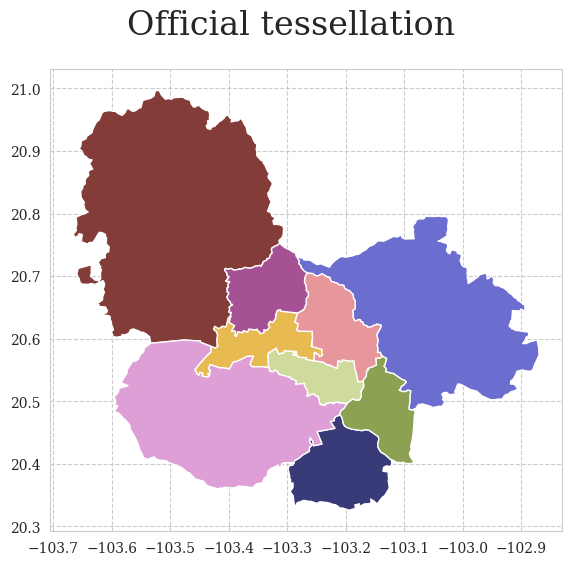

In [ ]:
tess_color = "tab20b"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6)) 
fig.suptitle('Official tessellation', fontsize = 24)


dict_tessellations['a1_t1'].plot(ax = ax, cmap = tess_color)

In [ ]:
dict_tessellations['a1_t2']

name                                           geometry       Caseta  \
0   cell 1  POLYGON ((-103.38895 20.58307, -103.37527 20.5...     Santa Fe   
1   cell 2  POLYGON ((-103.37536 20.64363, -103.38895 20.5...  Las Aguilas   
2   cell 3  POLYGON ((-103.61597 20.96111, -103.61561 20.9...     Atemajac   
3   cell 4  POLYGON ((-103.61083 20.73063, -103.61074 20.7...     Vallarta   
4   cell 5  POLYGON ((-103.30994 20.60673, -103.34265 20.6...  Tlaquepaque   
5   cell 6  MULTIPOLYGON (((-103.30257 20.67019, -103.3277...      Oblatos   
6   cell 7  POLYGON ((-103.29029 20.60244, -103.28001 20.6...  Loma Dorada   
7   cell 8  POLYGON ((-103.34265 20.64492, -103.36857 20.6...       Centro   
8   cell 9  POLYGON ((-103.30994 20.60673, -103.37527 20.5...    Miravalle   
9  cell 10  POLYGON ((-103.37527 20.57767, -103.30994 20.6...   Las Pintas   

         lat         lng  
0  20.528954 -103.377180  
1  20.630983 -103.416735  
2  20.719626 -103.355412  
3  20.680141 -103.398572  
4  20.640941 -103.312497  
5  20.700501 -103.296648  
6  20.631665 -103.256809  
7  20.673844 -103.333243  
8  20.614511 -103.343352  
9  20.576708 -103.326533

<Axes: >

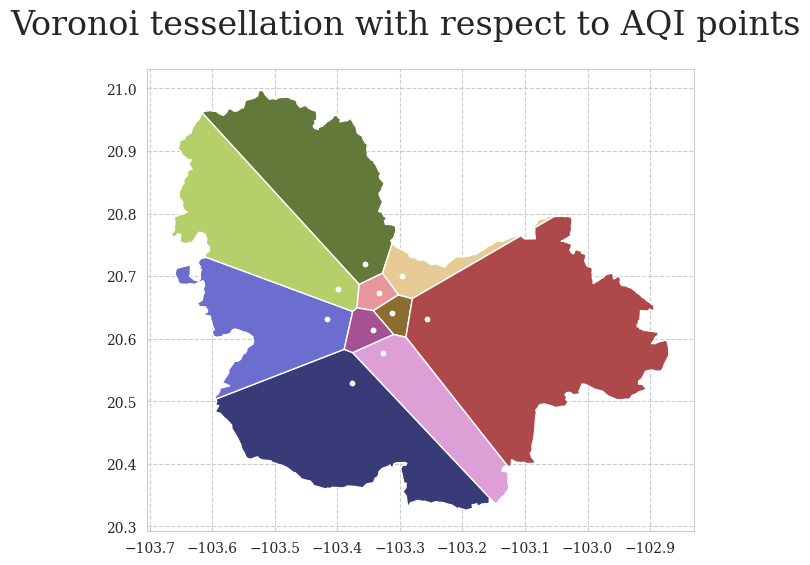

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6)) 
fig.suptitle('Voronoi tessellation with respect to AQI points', fontsize = 24)


dict_tessellations['a1_t2'].plot(ax = ax, cmap = tess_color)
points_gdf.plot(ax = ax, color = 'white', markersize = 10)

In [ ]:
# Visualizing trajectories flowing through Area 3
map_f = folium.Map(location = [20.66682, -103.39182], zoom_start = 10, tiles = 'CartoDB positron')

# Outlining official tessellation and adding name of counties as folium popup
for _, row in dict_tessellations['a1_t2'].iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data = geo_j, style_function = lambda x: {'fillColor': 'violet', 'color': 'purple'})
    folium.Popup(row['Caseta']).add_to(geo_j)
    # folium.Circle([row['lat'], row['lng']], radius = 12000, weight = 1).add_to(geo_j)
    folium.CircleMarker([row['lat'], row['lng']], radius = 1, weight = 8, color = 'red').add_to(geo_j)
    geo_j.add_to(map_f)

map_f

In [ ]:
# # Visualizing trajectories flowing through Area 3
# map_f = folium.Map(location = [20.66682, -103.39182], zoom_start = 10, tiles = 'CartoDB positron')

# # Outlining official tessellation and adding name of counties as folium popup
# for _, row in dict_tessellations['a1_t1'].iterrows():
#     sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data = geo_j, style_function = lambda x: {'fillColor': 'violet', 'color': 'purple'})
#     # folium.Circle([row['lat'], row['lng']], radius = 12000, weight = 1).add_to(geo_j)
#     folium.CircleMarker([row['lat'], row['lng']], radius = 1, weight = 8, color = 'red').add_to(geo_j)
#     geo_j.add_to(map_f)

# map_f

# **<font color="#ffb94f">2.0 DATA VISUALIZATION</font>**

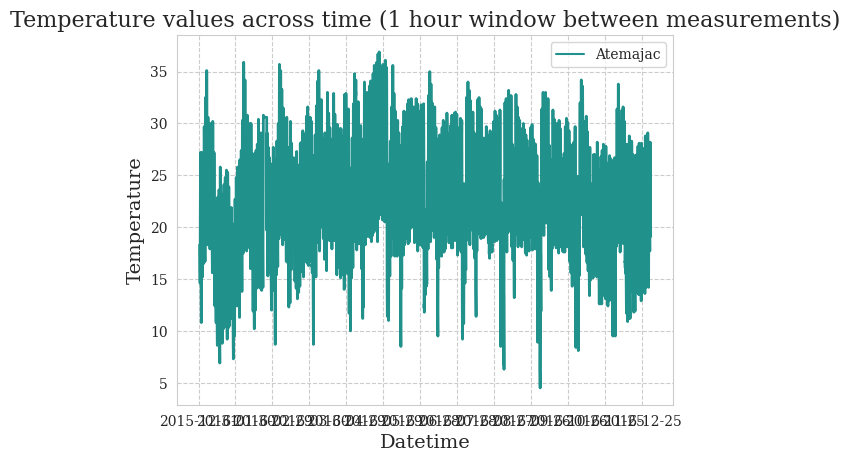

In [ ]:
ax = sns.lineplot(data = df_aqi[df_aqi['Station'] == 'Atemajac'], x ='Datetime', y = 'Temperature',
                  hue = 'Station', palette = 'viridis',
                  legend = 'full', lw = 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Temperature values across time (1 hour window between measurements)')
plt.show()

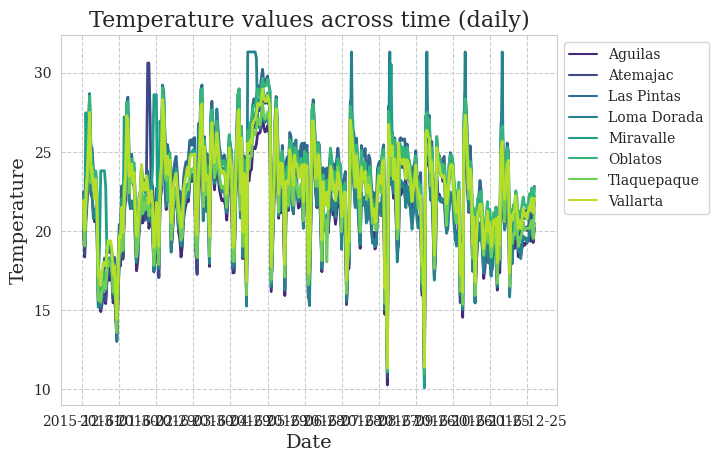

In [ ]:
ax = sns.lineplot(data = df_aqi_daily, x ='Date', y = 'Temperature',
                  hue = 'Station', palette = 'viridis',
                  legend = 'full', lw = 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Temperature values across time (daily)')
plt.show()

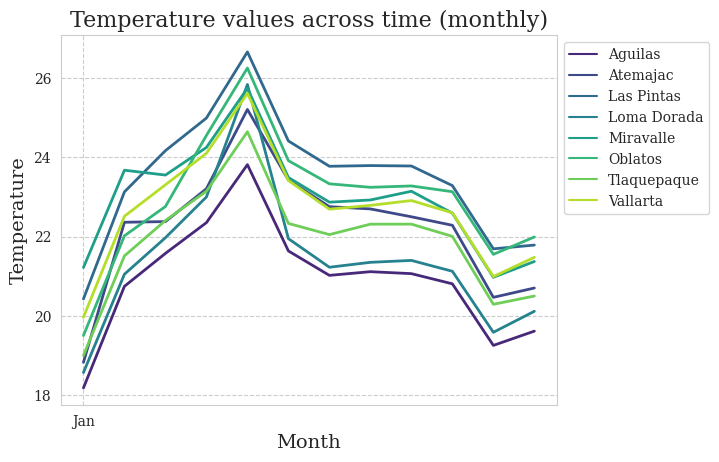

In [ ]:
ax = sns.lineplot(data = df_aqi_monthly, x ='Month', y = 'Temperature',
                  hue = 'Station', palette = 'viridis',
                  legend = 'full', lw = 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Temperature values across time (monthly)')
plt.show()

In [ ]:
#extract color palette, the palette can be changed
palette = list(sns.color_palette(palette = 'viridis', n_colors = len(list_monitor_station)).as_hex())

for feature in list_columns:
    fig = go.Figure()
    for station, p in zip(list_monitor_station, palette):
        fig.add_trace(go.Scatter(x = df_aqi_daily[df_aqi_daily['Station'] == station]['Date'],
                                y = df_aqi_daily[df_aqi_daily['Station'] == station][feature],
                                name = station,
                                line_color = p))
    fig.update_layout(title_text = '{} values across time (daily)'.format(feature), title_x = 0.5)
    fig.update_layout(autosize = False, width = 1200, height = 400,)
    fig.show()

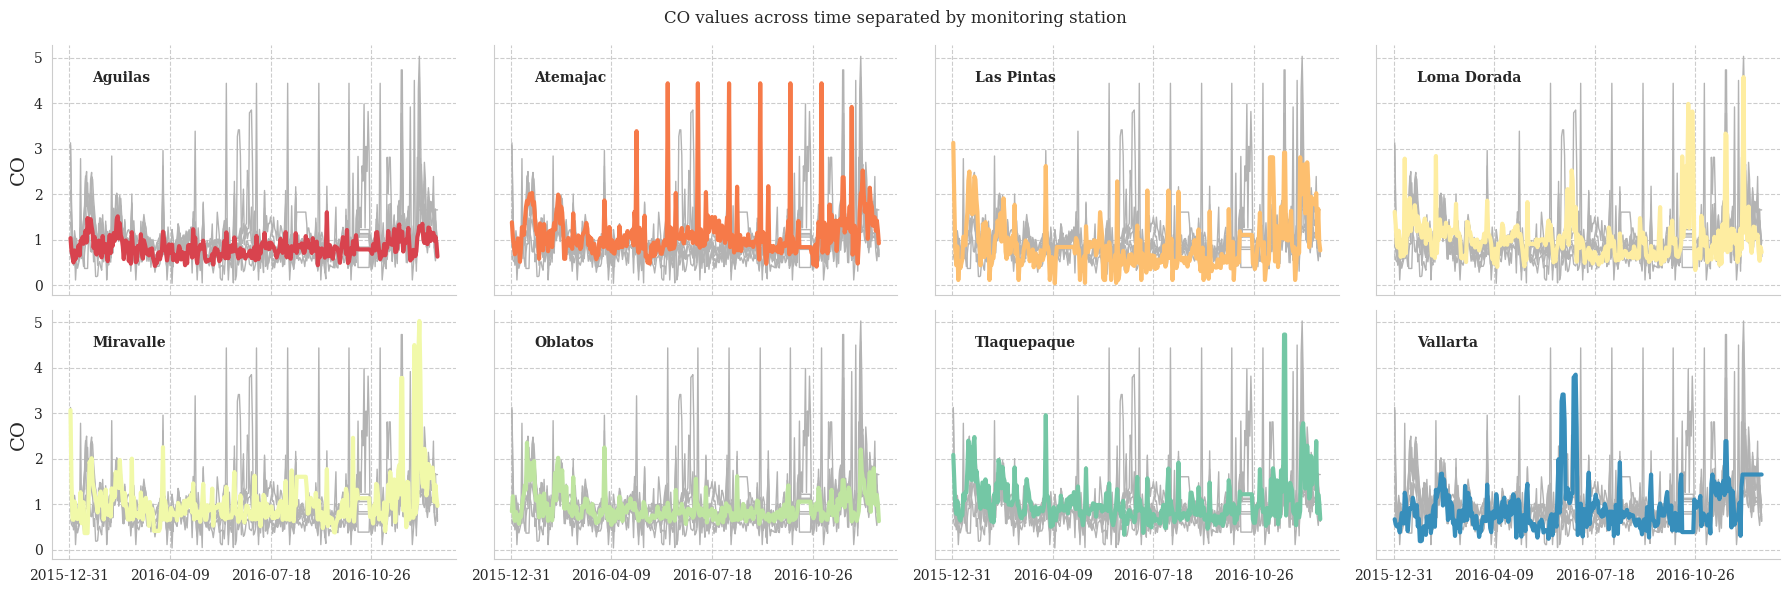

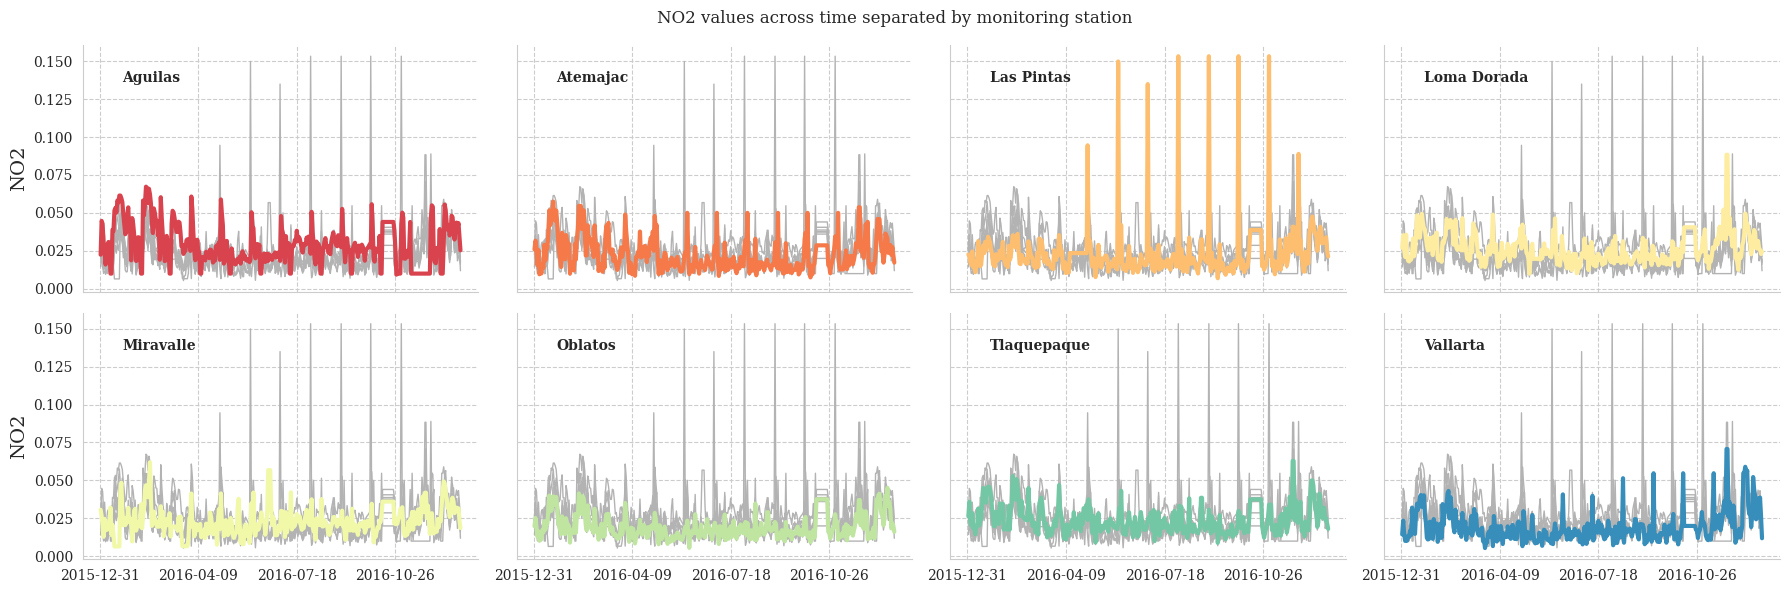

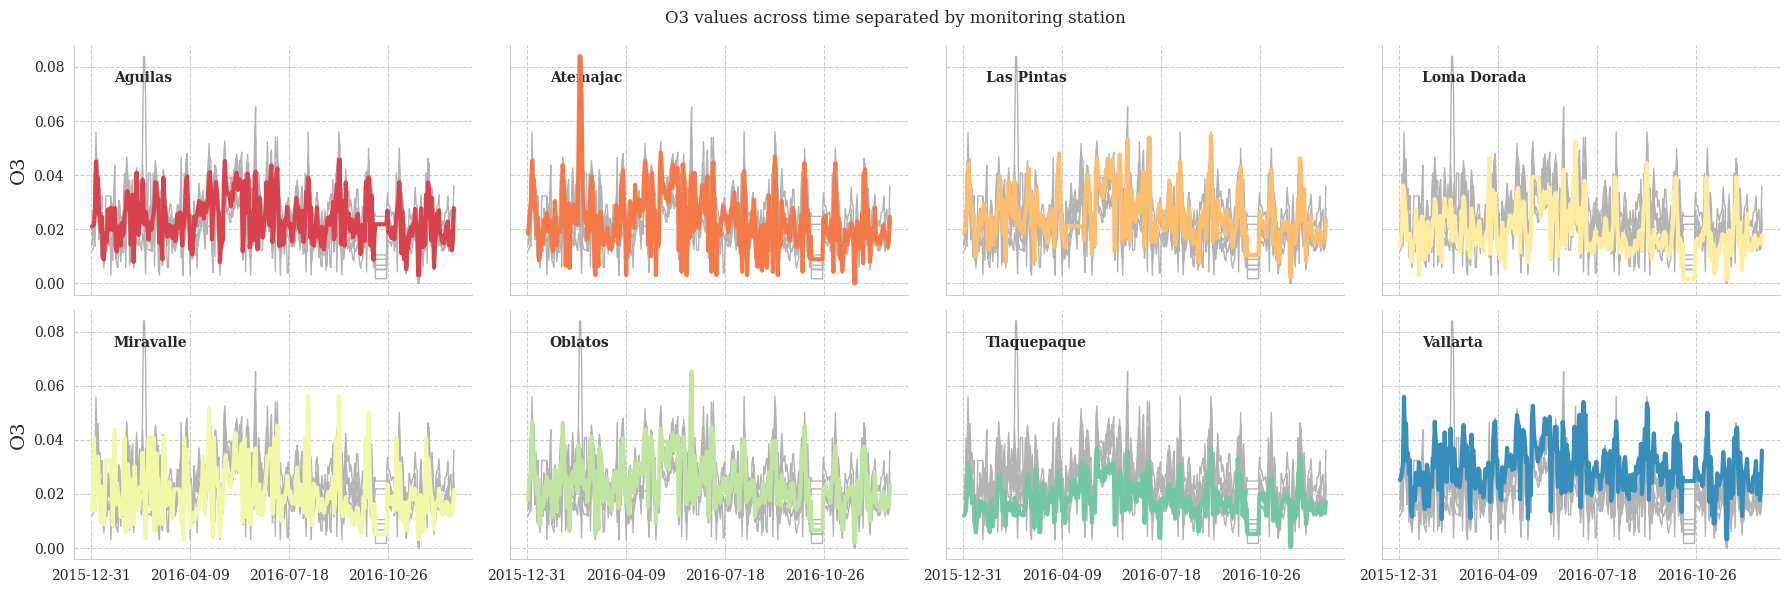

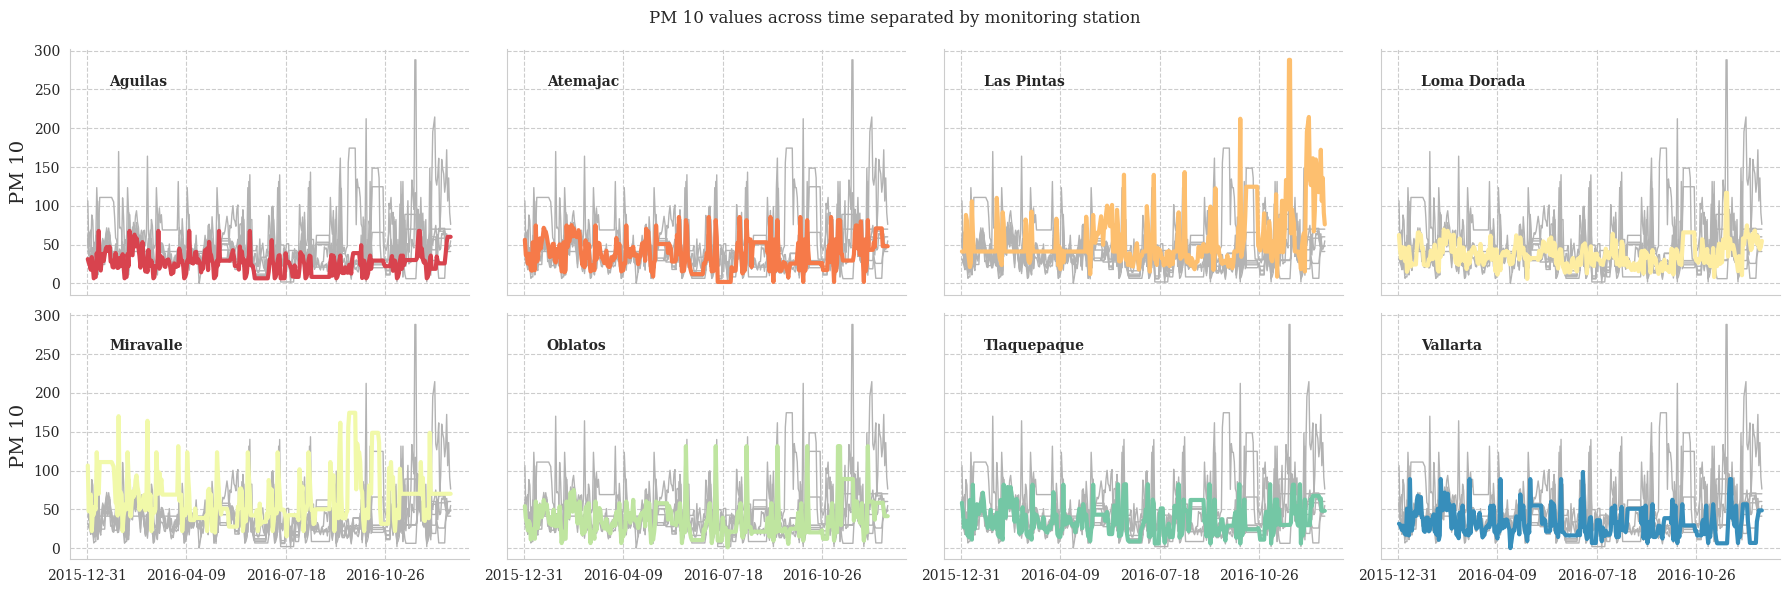

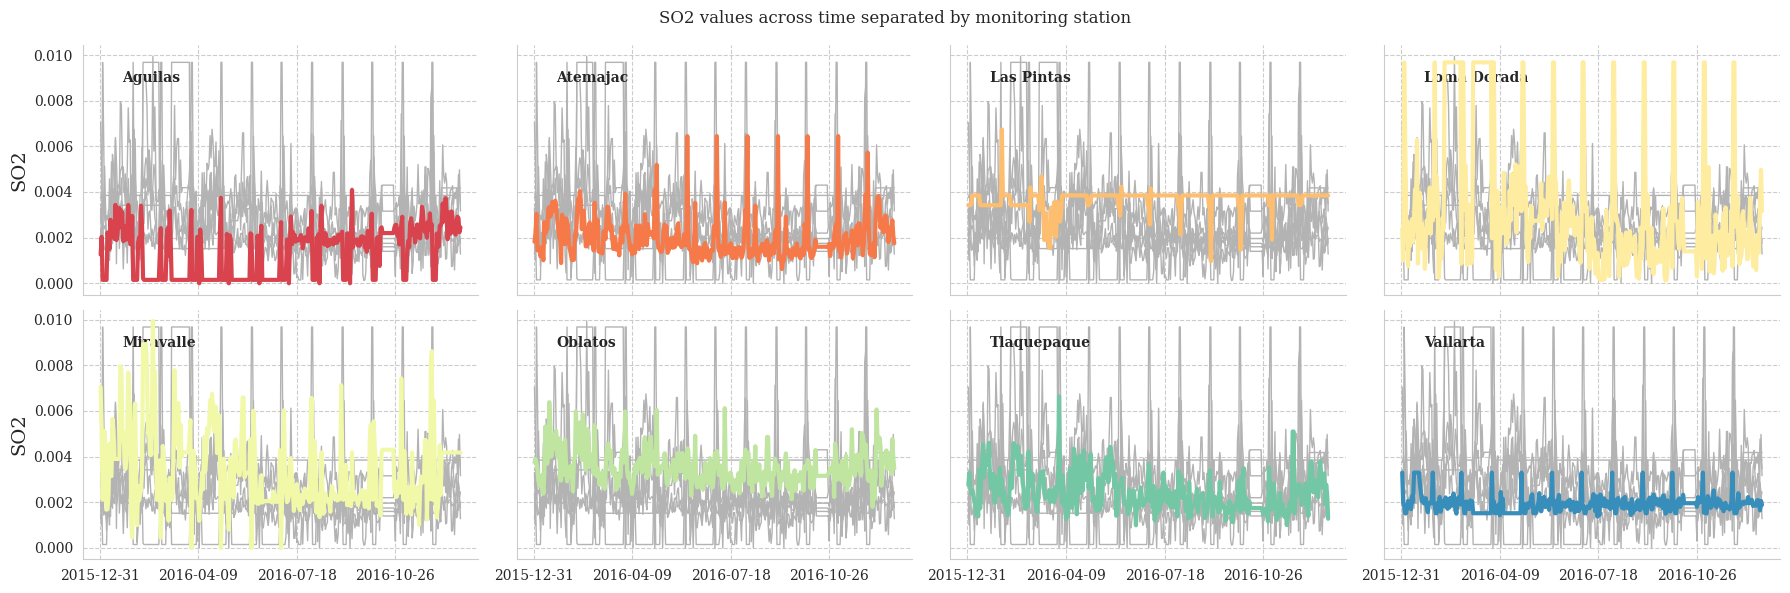

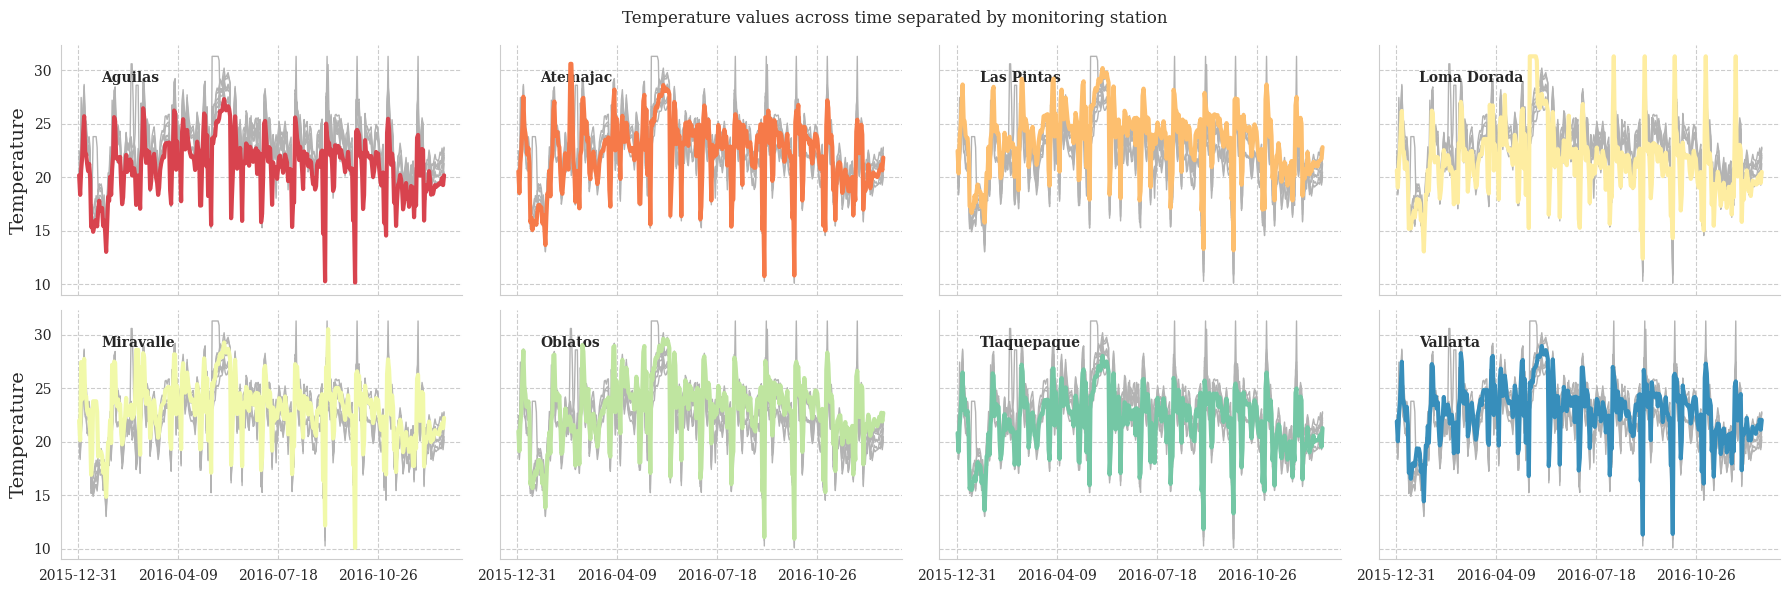

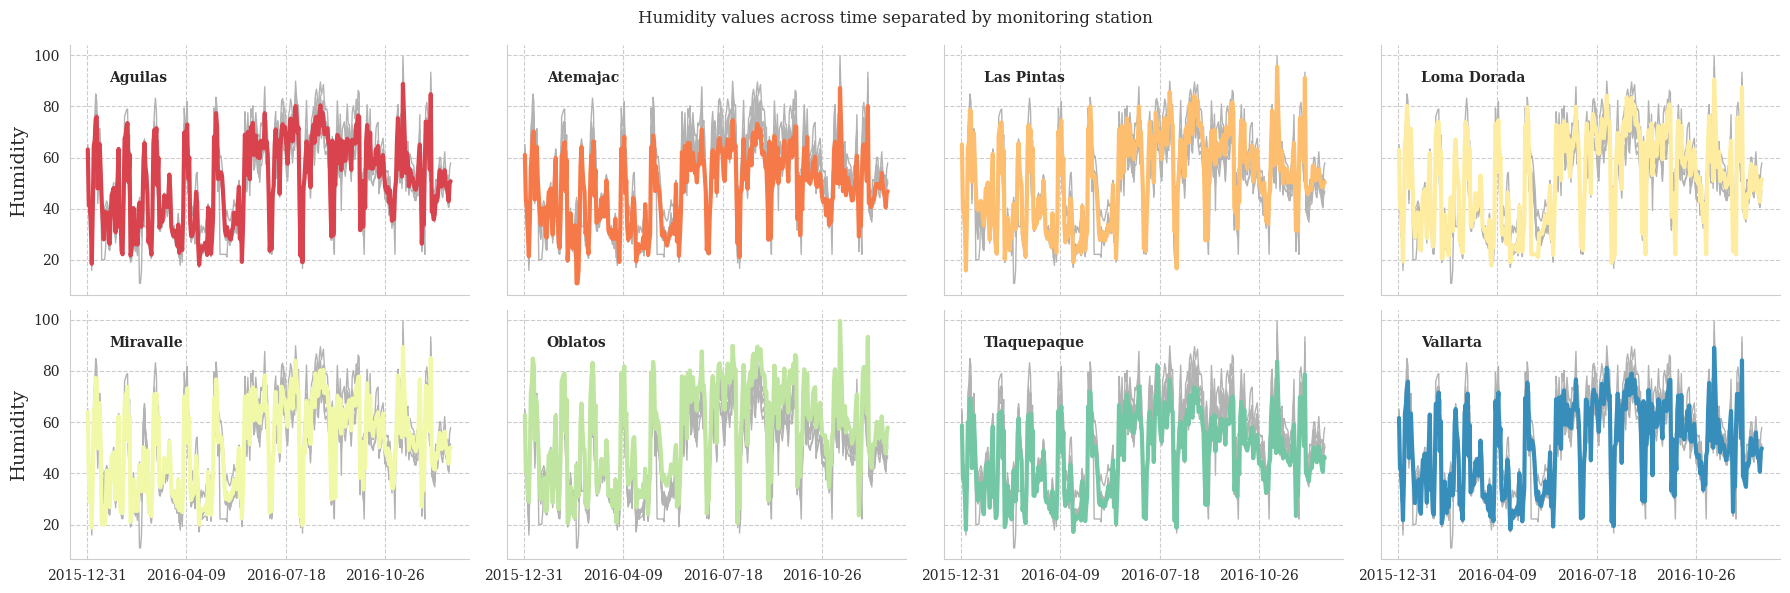

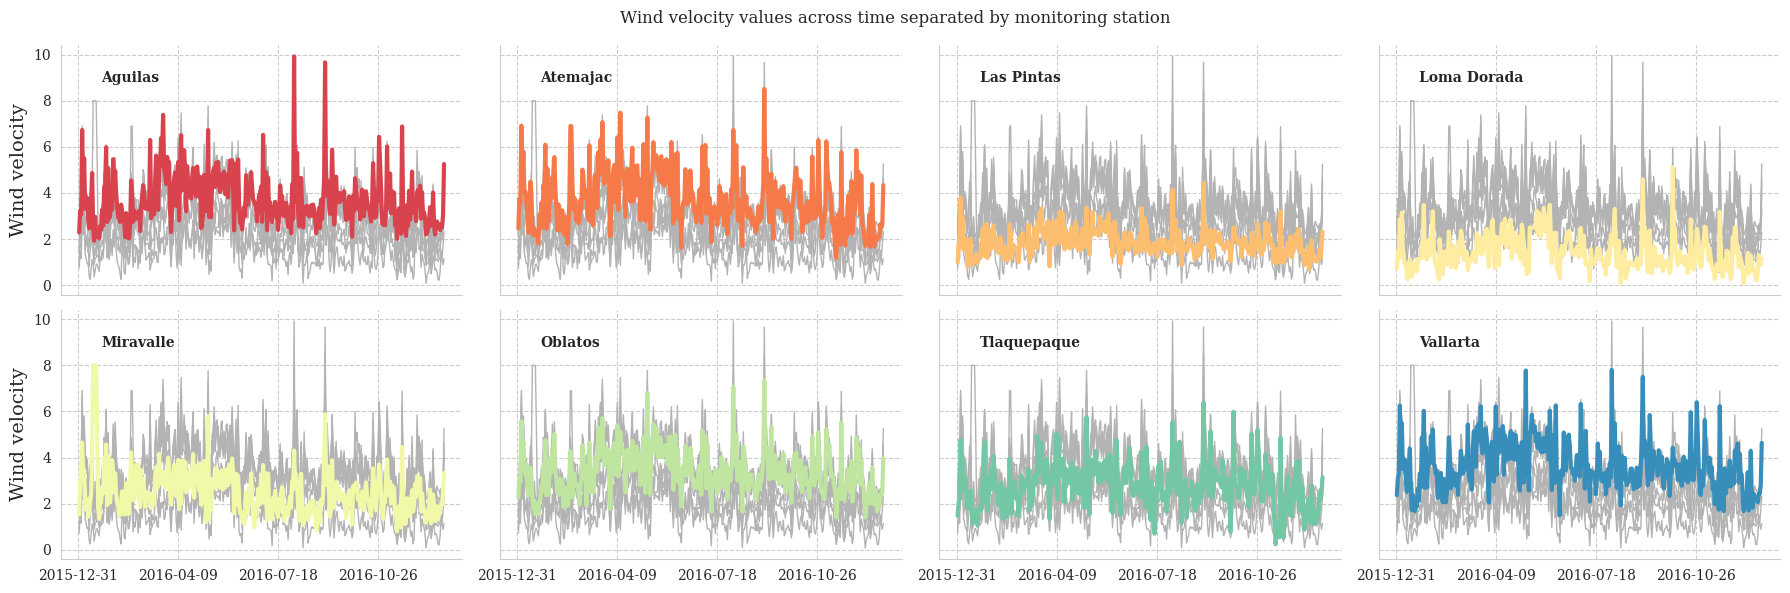

In [ ]:
for feature in list_columns:
    grid = sns.relplot(data = df_aqi_daily, x = "Date", y = feature,
                      col = "Station", hue = "Station",
                      kind = "line", palette = "Spectral",   
                      linewidth = 3, zorder = 4, col_wrap = 4, 
                      height = 3, aspect = 1.5, legend = False)

    #add text and silhouettes
    for time, ax in grid.axes_dict.items():
        ax.text(.1, .85, time, transform = ax.transAxes, fontweight = "bold")
        sns.lineplot(data = df_aqi_daily, x = "Date", y = feature, units = "Station",
                    estimator = None, color= ".7", linewidth = 1, ax = ax)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    grid.set_titles("")
    grid.fig.suptitle('{} values across time separated by monitoring station'.format(feature))
    grid.set_axis_labels("", "{}".format(feature))
    grid.tight_layout()

In [ ]:
for feature in list_columns:
    fig = go.Figure()
    
    for station, p in zip(list_monitor_station, palette):
        fig.add_trace(go.Scatterpolar(r = df_aqi_monthly[df_aqi_monthly['Station'] == station][feature],
                                      theta = df_aqi_monthly[df_aqi_monthly['Station'] == station]['Month'],
                                      name = station, marker = dict(color = p)))
    fig.update_layout(title_text = '{} values across time (monthly)'.format(feature), title_x = 0.5)
    fig.update_layout(showlegend=True, width=600, height=500)
    fig.show()  

# **<font color="#ffb94f">3.0 DIMENSIONALITY REDUCTION</font>**

## **<font color="#84f745">3.1 PCA</font>**

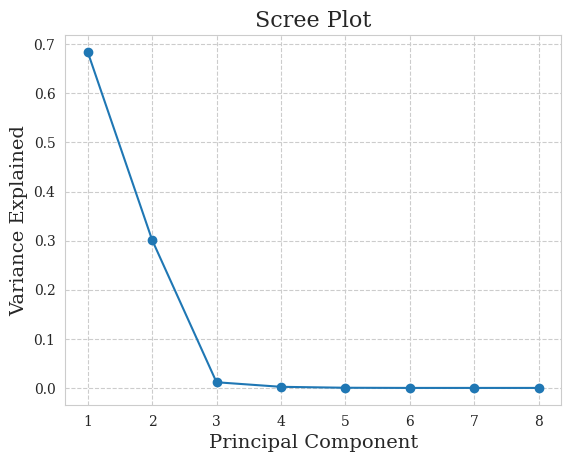

In [ ]:
pca = PCA(n_components=8)
Principal_components=pca.fit_transform(X_train)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

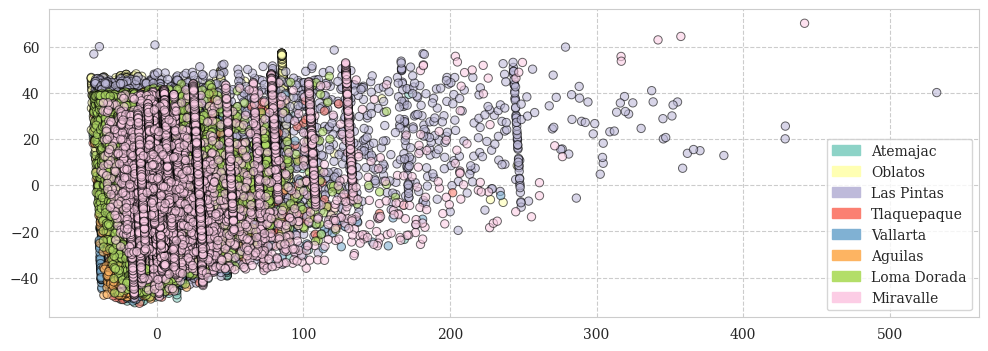

In [ ]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)

levels, categories = pd.factorize(df_aqi['Station'])
colors = [plt.cm.Set3(i) for i in levels]
handles = [matplotlib.patches.Patch(color = plt.cm.Set3(i), label = c) for i, c in enumerate(categories)]

fig = plt.figure(figsize = (12, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = colors, edgecolor = 'k', alpha = .6, linewidth = .7)
plt.legend(handles=handles)
plt.show()

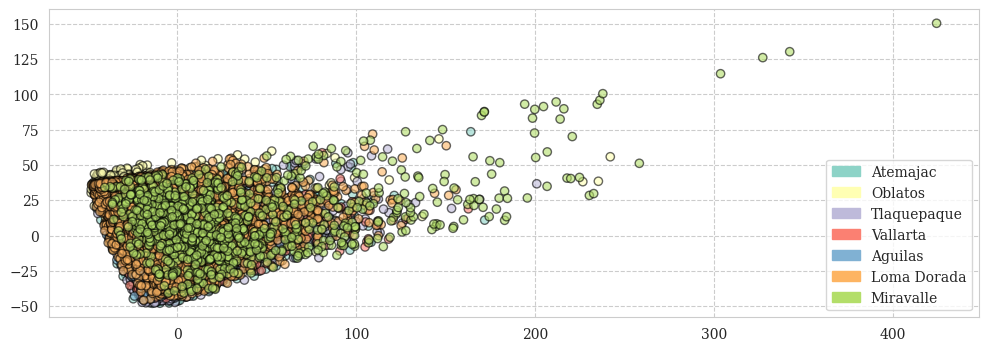

In [ ]:
pca = PCA(n_components = 2)
X_train_pca_dropna = pca.fit_transform(X_train_dropna)

levels, categories = pd.factorize(df_aqi_dropna['Station'])
colors = [plt.cm.Set3(i) for i in levels]
handles = [matplotlib.patches.Patch(color = plt.cm.Set3(i), label = c) for i, c in enumerate(categories)]

fig = plt.figure(figsize = (12, 4))
plt.scatter(X_train_pca_dropna[:, 0], X_train_pca_dropna[:, 1], c = colors, edgecolor = 'k', alpha = .6, linewidth = 1)
plt.legend(handles=handles)
plt.show()

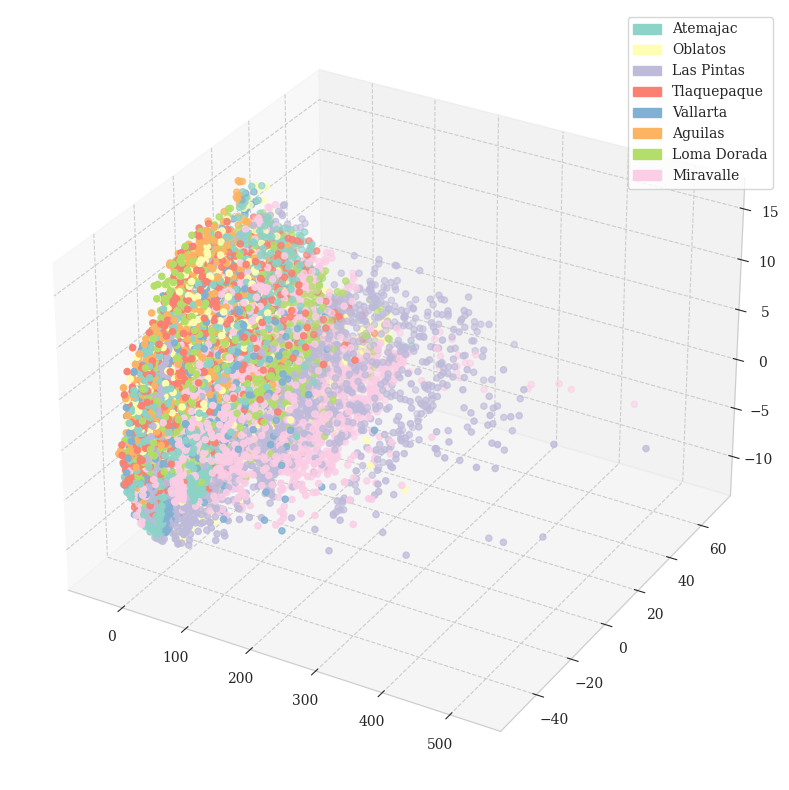

In [ ]:
pca = PCA(n_components=3)
aqi_pca = pca.fit_transform(X_train)

x = aqi_pca[:, 0]
y = aqi_pca[:, 1]
z = aqi_pca[:, 2]

levels, categories = pd.factorize(df_aqi['Station'])
colors = [plt.cm.Set3(i) for i in levels]
handles = [matplotlib.patches.Patch(color = plt.cm.Set3(i), label = c) for i, c in enumerate(categories)]

fig = plt.figure(figsize = (15, 10))
fig.tight_layout()
ax = plt.axes(projection = "3d")
ax.scatter3D(x, y, z, c = colors)
plt.legend(handles=handles)
plt.show()

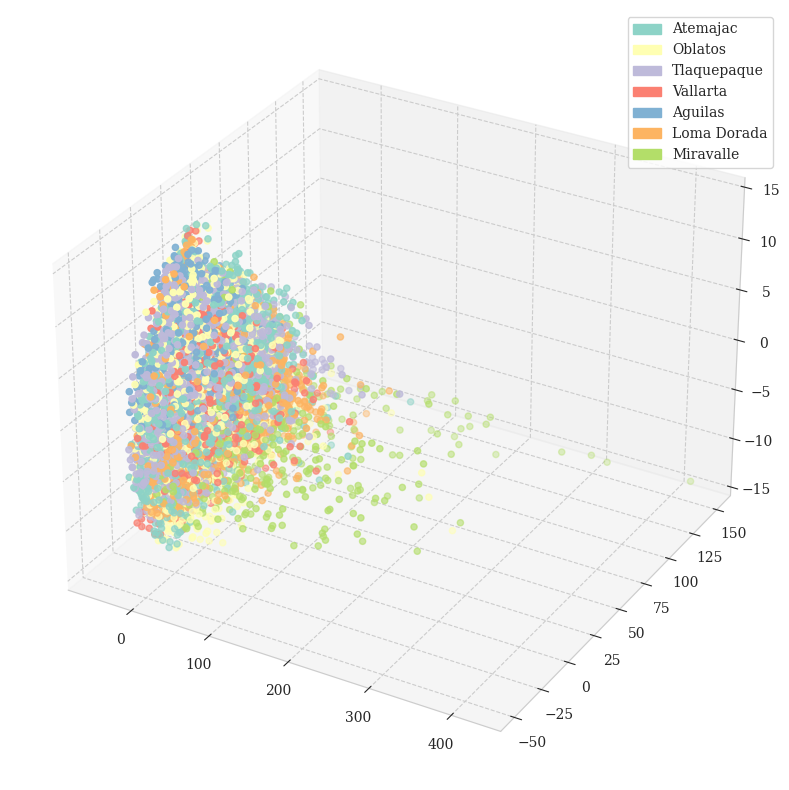

In [ ]:
pca = PCA(n_components=3)
aqi_pca = pca.fit_transform(X_train_dropna)

x = aqi_pca[:, 0]
y = aqi_pca[:, 1]
z = aqi_pca[:, 2]

levels, categories = pd.factorize(df_aqi_dropna['Station'])
colors = [plt.cm.Set3(i) for i in levels]
handles = [matplotlib.patches.Patch(color = plt.cm.Set3(i), label = c) for i, c in enumerate(categories)]

fig = plt.figure(figsize = (15, 10))
fig.tight_layout()
ax = plt.axes(projection = "3d")
ax.scatter3D(x, y, z, c = colors)
plt.legend(handles=handles)
plt.show()

## **<font color="#84f745">3.2 GAUSSIAN RANDOM PROJECTION</font>**

Text(0.5, 1.0, 'Gaussian Random Projection')

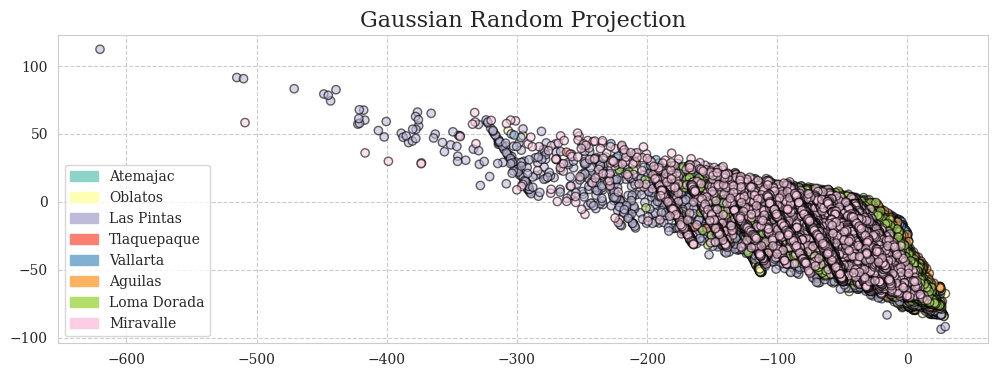

In [ ]:
rsp = random_projection.GaussianRandomProjection(n_components = 2)
aqi_rsp = rsp.fit_transform(X_train)

levels, categories = pd.factorize(df_aqi['Station'])
colors = [plt.cm.Set3(i) for i in levels]
handles = [matplotlib.patches.Patch(color = plt.cm.Set3(i), label = c) for i, c in enumerate(categories)]

fig = plt.figure(figsize = (12, 4))
plt.scatter(aqi_rsp[:, 0], aqi_rsp[:, 1], c = colors, edgecolor = 'k', alpha = .6, linewidth = 1)
plt.legend(handles=handles)
plt.title("Gaussian Random Projection")

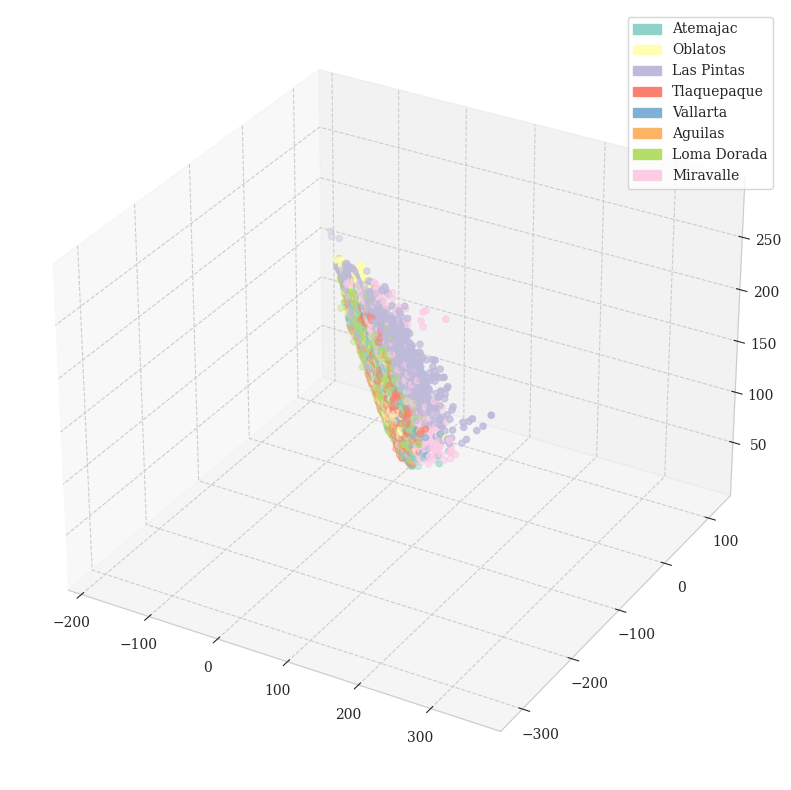

In [ ]:
rsp = random_projection.GaussianRandomProjection(n_components = 3)
aqi_rsp = rsp.fit_transform(X_train)

x = aqi_rsp[:, 0]
y = aqi_rsp[:, 1]
z = aqi_rsp[:, 2]

levels, categories = pd.factorize(df_aqi['Station'])
colors = [plt.cm.Set3(i) for i in levels]
handles = [matplotlib.patches.Patch(color = plt.cm.Set3(i), label = c) for i, c in enumerate(categories)]

fig = plt.figure(figsize = (15, 10))
fig.tight_layout()
ax = plt.axes(projection = "3d")
ax.scatter3D(x, y, z, c = colors)
plt.legend(handles=handles)
plt.show()

# **<font color="#ffb94f">4.0 OUTLIER DETECTION</font>**

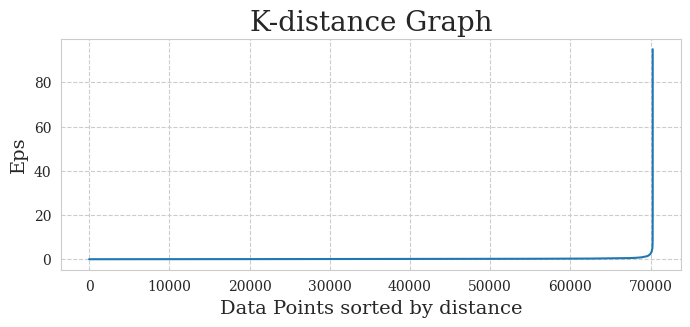

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Calcoliamo i valori di distanza tra ogni record e il suo nearest neighbor
nbr = NearestNeighbors(n_neighbors=2)
nbrs = nbr.fit(X_train_pca)
distances, indices = nbrs.kneighbors(X_train_pca)

# Plottiamo la distanza dentro i valori del df e cerchiamo il "gomito" per vedere il punto di massima curvatura e quindi il valore ottimo di Eps
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(8,3))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Eps',fontsize=14)
plt.show()

Outliers found by DBSCAN: 279


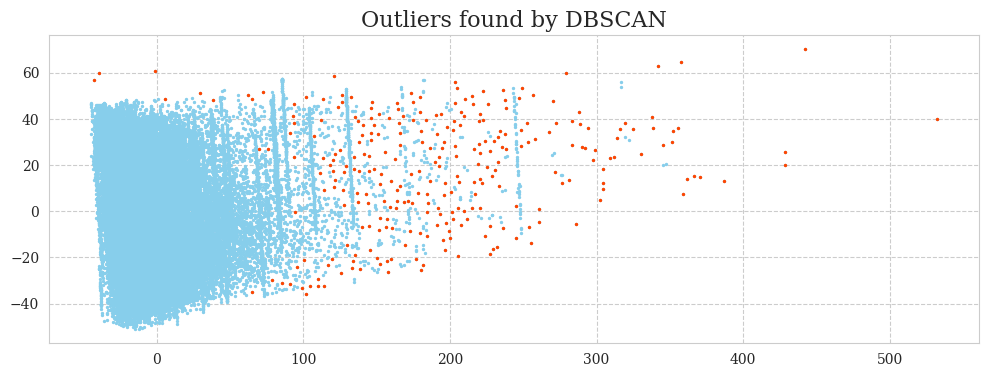

In [ ]:
dbscan = DBSCAN(eps = 2.5, min_samples = 2)
dbscan.fit(X_train_pca)

anomalies_db = np.where(dbscan.labels_ == -1)
anomalies_db_pca = X_train_pca[anomalies_db]
print('Outliers found by DBSCAN:', len(anomalies_db_pca))

fig = plt.figure(figsize = (12, 4))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color = 'skyblue', s = 2)
plt.scatter(anomalies_db_pca[:,0], anomalies_db_pca[:,1], color = 'orangered', s = 2)
plt.title("Outliers found by DBSCAN")
plt.show()

Outliers found by Isolation Forest: 209


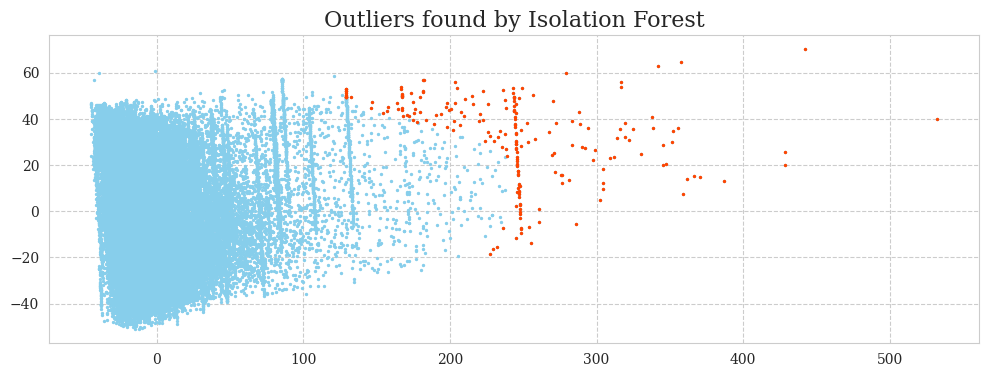

In [ ]:
isol = IsolationForest(bootstrap = True,  
                       contamination = 0.003, 
                       max_samples = 200, 
                       n_estimators = 1000, 
                       n_jobs = -1).fit(X_train_pca)

outliers_isol = isol.predict(X_train_pca)

anomalies_isol = np.where(outliers_isol == -1)
anomalies_isol_pca = X_train_pca[anomalies_isol]
print('Outliers found by Isolation Forest:', len(anomalies_isol_pca))

fig = plt.figure(figsize = (12, 4))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color='skyblue', s = 2)
plt.scatter(anomalies_isol_pca[:,0], anomalies_isol_pca[:,1], color='orangered', s = 2)
plt.title("Outliers found by Isolation Forest")
plt.show()

Outliers found by LOF: 211


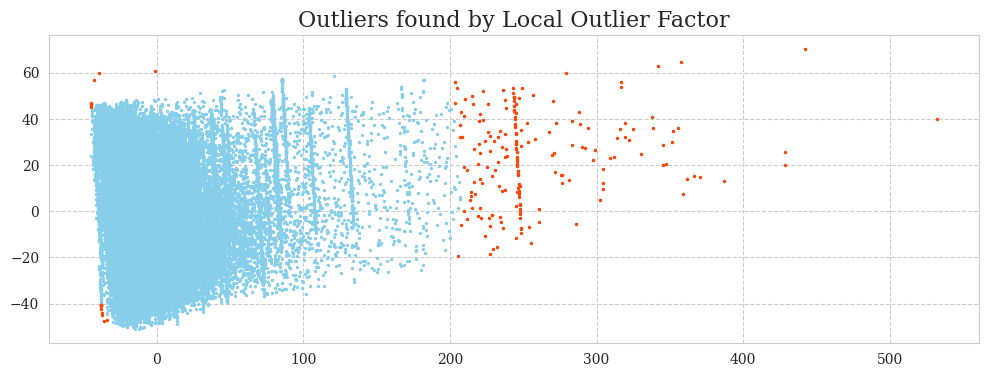

In [ ]:
lof = LocalOutlierFactor(n_neighbors = 1000,
                         contamination = .003,
                         algorithm = 'kd_tree')

outliers_lof = lof.fit_predict(X_train_pca)

anomalies_lof = np.where(outliers_lof == -1)
anomalies_lof_pca = X_train_pca[anomalies_lof]
print('Outliers found by LOF:', len(anomalies_lof_pca))

fig = plt.figure(figsize = (12, 4))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color = 'skyblue', s = 2)
plt.scatter(anomalies_lof_pca[:,0], anomalies_lof_pca[:,1], color = 'orangered', s = 2)
plt.title("Outliers found by Local Outlier Factor")
plt.show()

Final outliers: 211


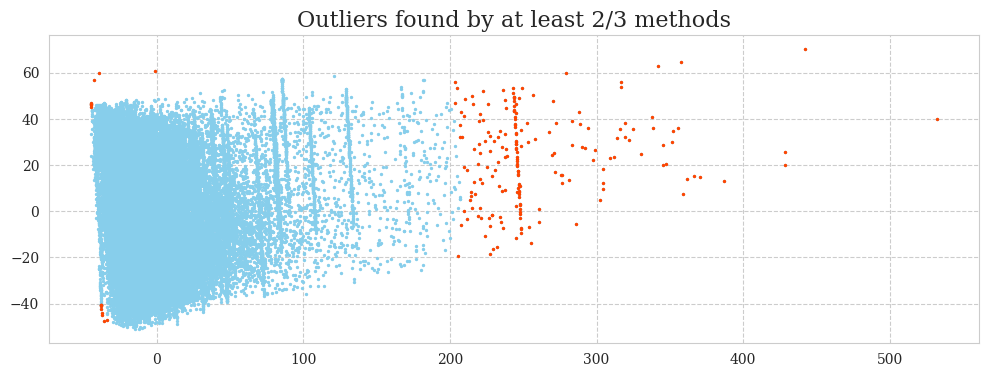

In [ ]:
list_all_outliers = []
for i,j,k in zip(anomalies_db, anomalies_lof, anomalies_lof):
    list_all_outliers.extend(i)
    list_all_outliers.extend(j)
    list_all_outliers.extend(k)

list_final_outliers = []
for item, count in collections.Counter(list_all_outliers).items(): 
    if count >= 2:
        list_final_outliers.append(item)

anomalies_final_pca = X_train_pca[list_final_outliers]
print('Final outliers:', len(anomalies_final_pca))

fig = plt.figure(figsize = (12, 4))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color = 'skyblue', s = 2)
plt.scatter(anomalies_final_pca[:,0], anomalies_final_pca[:,1], color = 'orangered', s = 2)
plt.title("Outliers found by at least 2/3 methods")
plt.show()

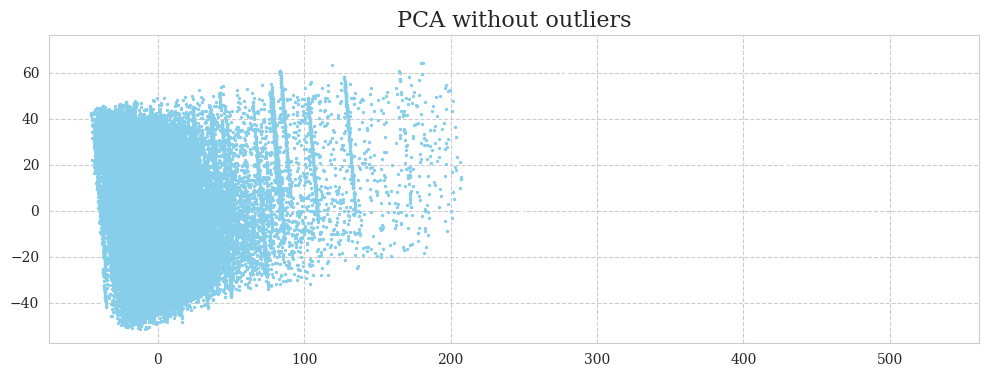

In [ ]:
df_aqi_noanomalies = df_aqi.copy()
df_aqi_noanomalies.drop(list_final_outliers, inplace = True)
df_aqi_noanomalies = df_aqi_noanomalies.reset_index(drop = True)

X_train_noanomalies = df_aqi_noanomalies.iloc[:,1:9]
pca = PCA(n_components = 2)
X_train_noanomalies_pca = pca.fit_transform(X_train_noanomalies)

fig = plt.figure(figsize = (12, 4))
plt.scatter(X_train_noanomalies_pca[:,0], X_train_noanomalies_pca[:,1], color = 'skyblue', s = 2)
plt.scatter(anomalies_final_pca[:,0], anomalies_final_pca[:,1], color = 'white', s = 2)
plt.title("PCA without outliers")
plt.show()

In [ ]:
df_aqi_noanomalies.describe()

CO           NO2            O3         PM 10           SO2  \
count  70059.000000  70059.000000  70059.000000  70059.000000  70059.000000   
mean       0.974334      0.023487      0.022870     40.569263      0.002719   
std        0.822299      0.016538      0.018471     30.157865      0.001802   
min        0.002100      0.000550      0.000000     -1.090000      0.000000   
25%        0.531000      0.011650      0.006980     20.940000      0.001640   
50%        0.759000      0.019700      0.019520     32.760000      0.002300   
75%        1.116000      0.031370      0.033900     51.105000      0.003630   
max       12.000000      0.335270      0.136950    248.050000      0.027220   

        Temperature      Humidity  Wind velocity  
count  70059.000000  70059.000000   70059.000000  
mean      22.327674     50.908637       2.887665  
std        5.028116     22.021566       2.176810  
min        4.100000      1.800000       0.000000  
25%       19.000000     33.700000       1.300000  
50%       22.000000     50.100000       2.500000  
75%       25.800000     68.500000       4.000000  
max       38.000000    100.900000      20.400000

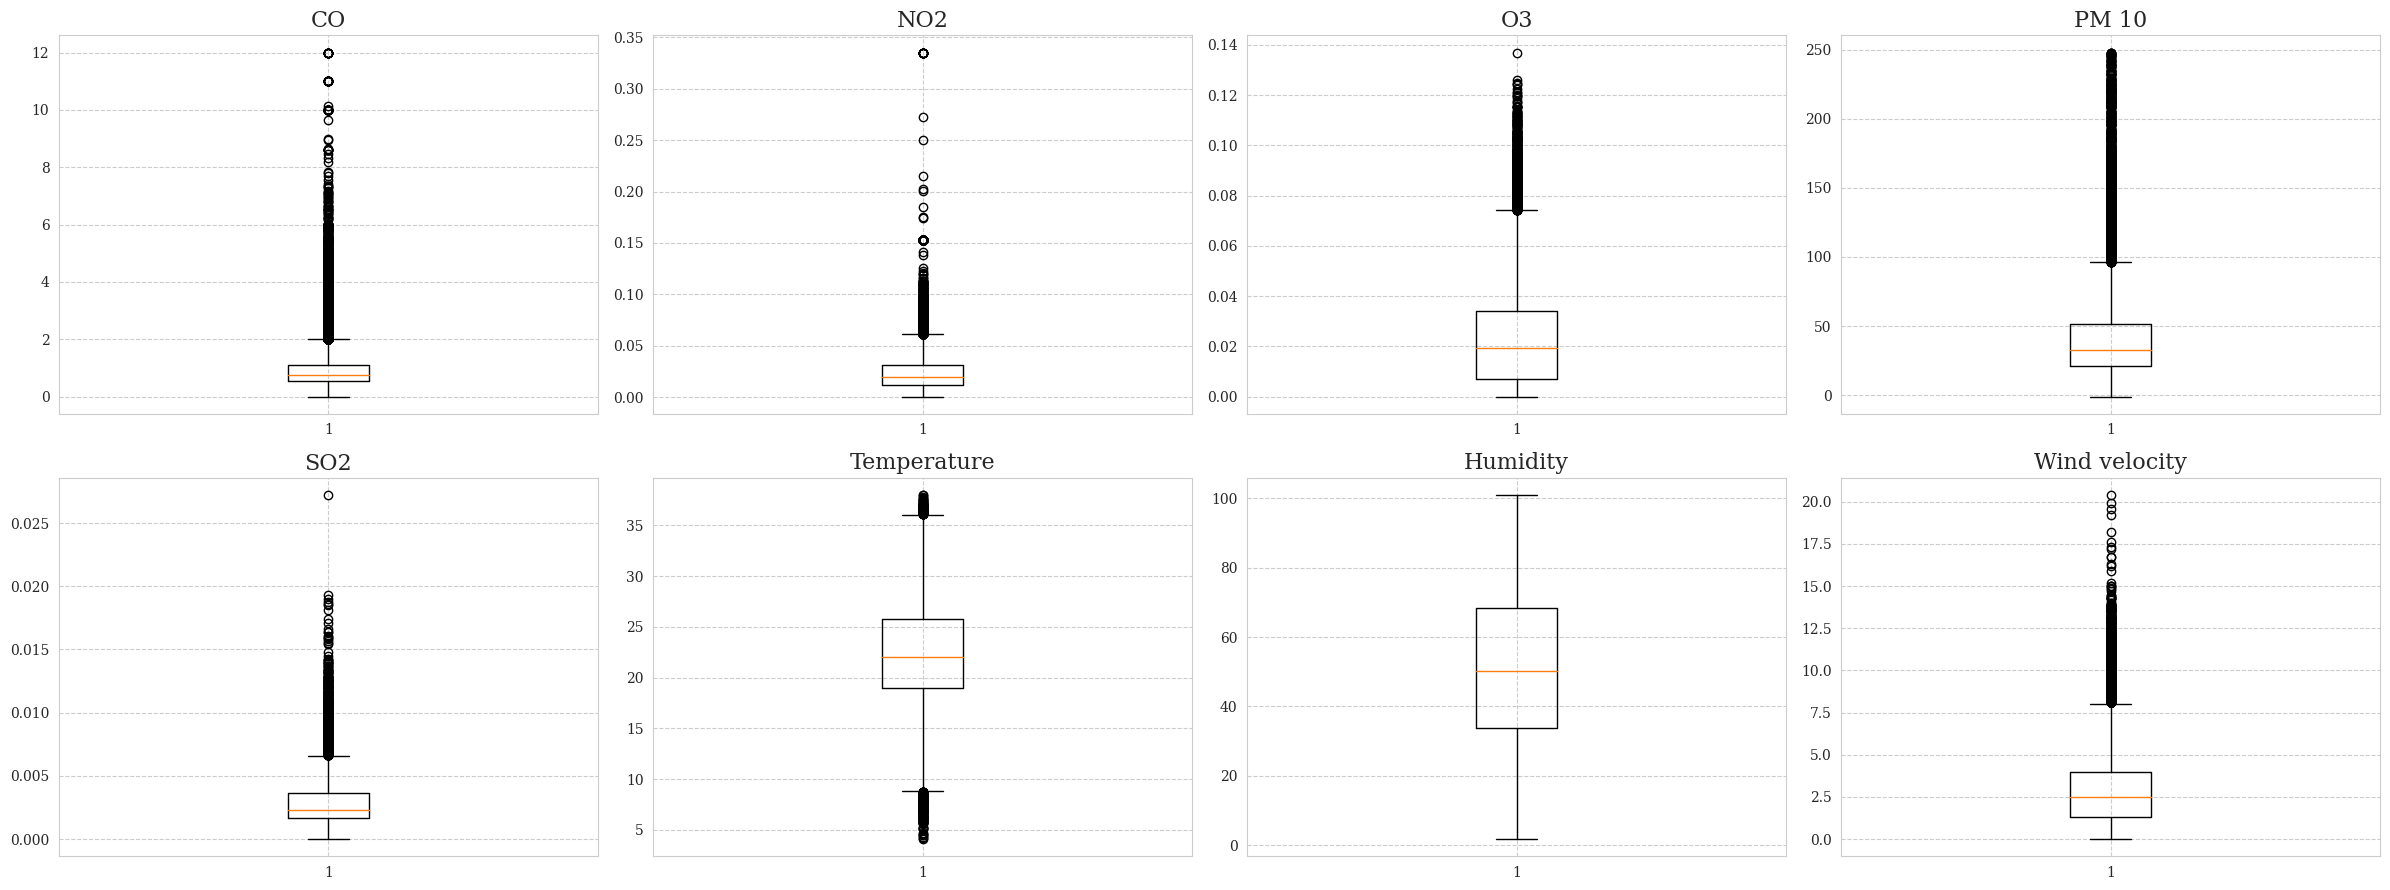

In [ ]:
# Plotting histogram for each feature in dataset of values imputed with the mean to look deeper into the SO2 anomaly
list_values_noanomalies = [df_aqi_noanomalies.iloc[:,i].values for i in range(1,9)]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 9))
k = 0
for i in range(2):
    for j in range(4):
        ax[i,j].boxplot(list_values_noanomalies[k])
        ax[i,j].set(title = list_columns[k])
        fig.tight_layout()
        k += 1

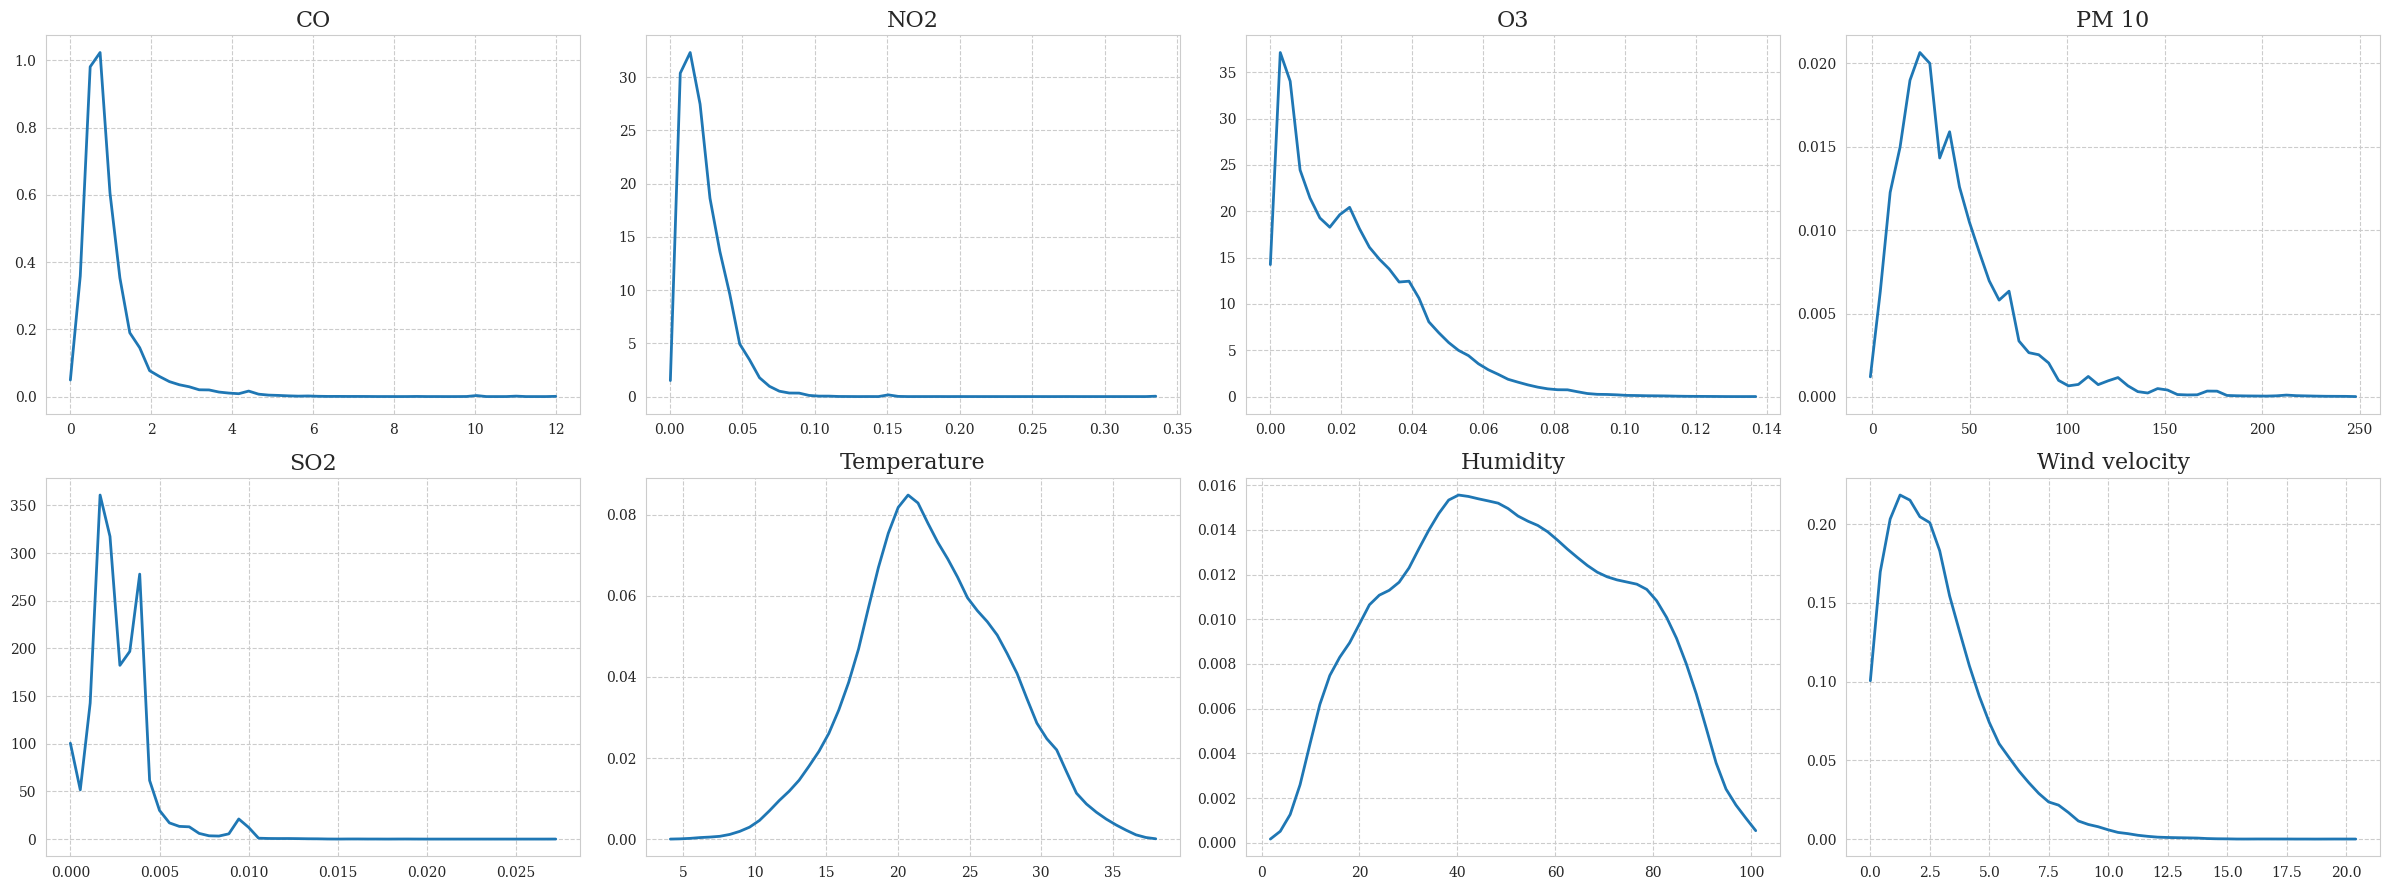

In [ ]:
# Obtaining distribution of each feature using KDE method
list_x = []
list_y = []

for i in range(len(list_values_noanomalies)):
    kde = gaussian_kde(list_values_noanomalies[i])
    x = np.linspace(min(list_values_noanomalies[i]), max(list_values_noanomalies[i]), 50)
    list_x.append(x)
    list_y.append(kde(x))

# Plotting histogram for each feature in dataset
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 9))
k = 0
for i in range(2):
    for j in range(4):
        ax[i,j].plot(list_x[k], list_y[k], linewidth = 2)
        ax[i,j].set(title = list_columns[k])
        fig.tight_layout()
        k += 1

# **<font color="#ffb94f">5.0 REGRESSION</font>**

Number of CPUs in the system: 2


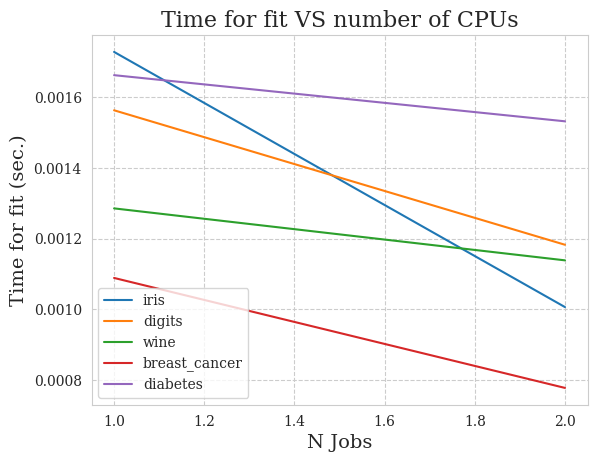

In [ ]:
import os
import time
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
import matplotlib.pyplot as plt
import pandas as pd

datasets_list = ['iris', 'digits', 'wine', 'breast_cancer','diabetes']

n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

parameters = {  'n_neighbors'   : np.arange(2, 25),
                'weights'       : ['uniform', 'distance'],
                'metric'        : ['euclidean', 'manhattan', 
                                   'chebyshev', 'minkowski'],
                'algorithm'     : ['ball_tree', 'kd_tree']
            }

def load_and_train(name):
    dataset = globals()['load_' + name]()
    X = dataset.data
    y = dataset.target

    tdelta_list = []
    for i in range(1, n_cpu+1):
        s = time.time()
        model = KNeighborsClassifier(n_jobs = i)
        clf = GridSearchCV(model, parameters, cv = 10)
        model.fit(X, y)
        e = time.time()
        tdelta = e - s 
        tdelta_list.append({'time' : tdelta, 'bin' : i})
    return tdelta_list

for d in datasets_list:
    tdelta_list = load_and_train(d)
    df = pd.DataFrame(tdelta_list)
    plt.plot(df['bin'], df['time'], label = d)

plt.legend(loc = 'best')
plt.xlabel('N Jobs')
plt.ylabel('Time for fit (sec.)')
plt.title('Time for fit VS number of CPUs')
plt.show()

# **<font color="#ffb94f">6.0 TIME SERIES ANALYSIS</font>**